
# **2 Training**

Scientific Computing Infrastructure


## 1. Preparations
### 1.1 Import required packages

In [15]:
import json
import os
import zipfile
import numpy as np
import geopandas as gpd
import sklearn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import importlib
import pickle

In [16]:
print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

from torch import nn

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


### 1.2 Install segmentation model library

In [17]:
# !pip install segmentation-models-pytorch

In [18]:
import segmentation_models_pytorch as smp

### 1.3 Set device agnostic code

In [19]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU identified")

CUDA available: True
CUDA Version: 12.4
Number of GPUs: 1
GPU Name: NVIDIA A30


In [20]:
# use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.4 Import data directories and configs-file

In [21]:
import os
print(os.path.abspath("configs"))

/home/sc.uni-leipzig.de/rf37uqip/MoSE/notebooks/configs


In [22]:
# path to repository folder
import sys
sys.path.append(os.path.abspath('/home/sc.uni-leipzig.de/rf37uqip/MoSE/'))

In [23]:
# import configs.py-file
from configs import configs_sc
importlib.reload(configs_sc) # reload changes

<module 'configs.configs_sc' from '/home/sc.uni-leipzig.de/rf37uqip/MoSE/configs/configs_sc.py'>

In [24]:
# input directories: patches and masks
patches_dir = configs_sc.DATA_DIR["patches"]
masks_dir = configs_sc.DATA_DIR["masks"]

# output directories: trained models
models_dir = configs_sc.DATA_DIR["models"]

# additional directories: class (labels and) codes
# labels_dir = configs_sc.DATA_DIR["labels"]
codes_dir = configs_sc.DATA_DIR["codes"]

### 1.5 Import and reload scripts

In [25]:
# import data_utils.py helper-functions script
from scripts import data_utils
importlib.reload(data_utils) # reload changes

# import model_utils.py helper-functions script
from scripts import model_utils
importlib.reload(model_utils) # reload changes

# import train_utils.py helper-functions script
from scripts import train_utils
importlib.reload(train_utils) # reload changes

# import evaluation_utils.py helper-functions script
from scripts import evaluation_utils
importlib.reload(evaluation_utils) # reload changes

# import visualization_utils.py helper function script
from scripts import visualization_utils
importlib.reload(visualization_utils) # reload changes

<module 'scripts.visualization_utils' from '/home/sc.uni-leipzig.de/rf37uqip/MoSE/scripts/visualization_utils.py'>

### 1.6 Check the data

a. Class codes dict

In [26]:
codes_path = os.path.join(codes_dir, "label_codes_ohe.json") # path

# open and load the JSON file
with open(codes_path, "r") as json_file:
    codes = json.load(json_file)

# reversed dictionary
reversed_codes = {v: k for k, v in codes.items()} # v = value, k = key
reversed_codes = {k: reversed_codes[k] for k in sorted(reversed_codes)} # sort by keys
print(reversed_codes)

FileNotFoundError: [Errno 2] No such file or directory: '/lscratch/data/codes/label_codes_ohe.json'

b. Preprocessed patches

In [13]:
# list of all .npy-files (preprocessed patches)
################################################################################
patches_list = [f for f in os.listdir(patches_dir) if f.endswith('.npy')]
# patches_list[0:3]
len(patches_list)

3836

Shape of the patches: (3, 512, 512)
Datatype: float64
Type: <class 'numpy.ndarray'>
Mean: 0.17565934532858182
Minimum value: -2.1179039301310043
Maximum value: 2.6225708061002178
A06_patch_200.npy


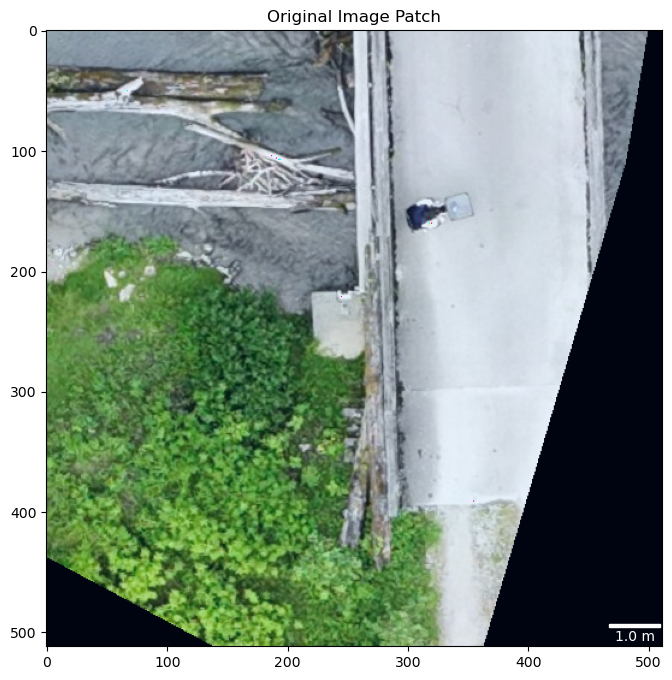

In [14]:
# Test one preprocessed patch
################################################################################

##################### choose single patch by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 200 # -------------------->> ADJUSTABLE
#####################

# load the path to the patch
test_patch_name = f"{SECTION}_patch_{TEST_PATCH_ID}.npy"
test_patch_path = patches_dir + f"/" + test_patch_name

# load npz-file
test_patch = np.load(test_patch_path)

  # Show characteristics of the patch
print("Shape of the patches:", test_patch.shape)
print("Datatype:", test_patch.dtype)
print("Type:", type(test_patch))
print("Mean:", np.mean(test_patch))
print("Minimum value:", np.min(test_patch))
print("Maximum value:", np.max(test_patch))

# import the norm_plot_patch function for normalization and plotting of the test patch
visualization_utils.norm_plot_patch(test_patch, test_patch_name)

3. Masks

In [15]:
# list of all masks
################################################################################

masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # list of all masks
# print(masks_list[0:3])
len(masks_list)

3836

In [16]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 200 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen mask
test_mask_name = f"{SECTION}_patch_{TEST_MASK_ID}_mask.npy"
test_mask_path = masks_dir + f"/" + test_mask_name

# Load mask
test_mask = np.load(test_mask_path)

# Show properties of the mask
print("Shape of the mask:", test_mask.shape)
print("Datatype:", test_mask.dtype)
print("Type:", type(test_mask))
print("Minimum value:", np.min(test_mask))
print("Maximum value:", np.max(test_mask))
print("Unique values:", np.unique(test_mask), "\n") # binary mask



Shape of the mask: (5, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 1
Unique values: [0 1] 



Plot the mask

A06_patch_200_mask.npy


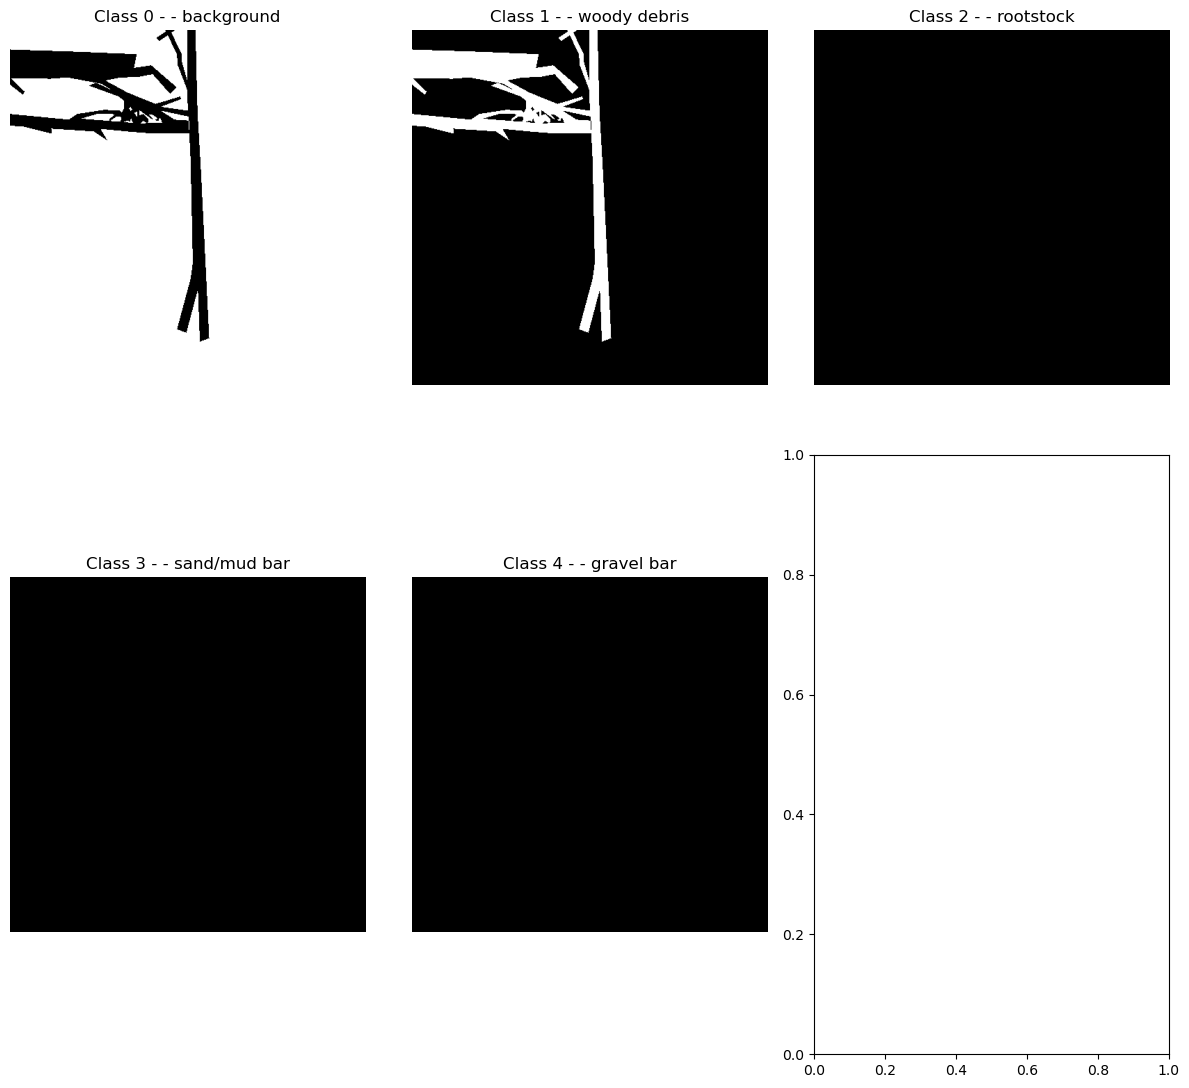

In [17]:
# ONE-HOT-ENCODED
print(test_mask_name)
fig, axes = plt.subplots(2, 3, figsize=(12, 12))  # 2x3 grid (for 5 classes)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask.shape[0]):  # iterate through the classes
  axes[i].imshow(test_mask[i], cmap="gray")
  axes[i].set_title(f"Class {i} - - {reversed_codes[i]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

A06_patch_200_mask.npy


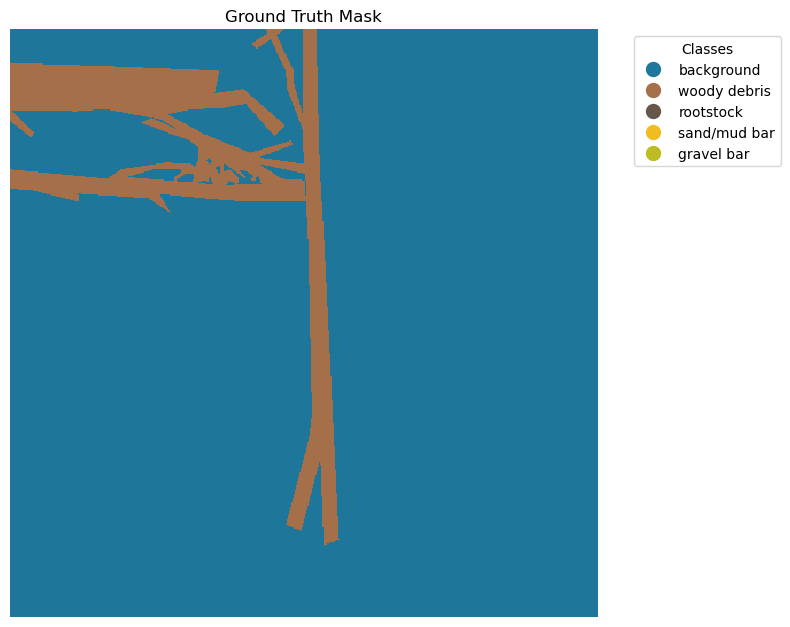

In [18]:
# alternative way of plotting the masks - not in one-hot-encoded, but in class-index-format
# CLASS-INDEX-FORMAT

# convert into class-index format
test_mask_idxformat = np.argmax(test_mask, axis=0)

visualization_utils.plot_mask_idxformat(test_mask_idxformat, test_mask_name, reversed_codes, configs_sc.HYPERPARAMETERS["custom_colors"])

## 2. Splitting data into train and test datasets

In [19]:
# extract section and patch_id from masks and patches (utils function)
# print(data_utils.extract_section_and_id(masks_list[2]))
# print(data_utils.extract_section_and_id(patches_list[175]))

In [20]:
# group patches by section
################################################################################

section_patches = {} # empty dictionary
for patch in patches_list: # iterate over all preprocessed patches
    section, patch_id = data_utils.extract_section_and_id(patch) # extract section and id
    section_patches.setdefault(section, []).append((patch)) # creates keys of sections with their patches inside

print(section_patches.keys())
# print(section_patches)

dict_keys(['A01', 'A02', 'A04', 'A06', 'A03', 'A05', 'A07', 'A08'])


In [21]:
# Separate patches in Training and Validation/Test datasets by sections
################################################################################

# empty lists for patches
train_data = []
test_data = []

for section, files in section_patches.items(): # iterates through the dictionary of sections
    if section in configs_sc.HYPERPARAMETERS["train_sections"]: # if the section is a training section
        train_data.extend(files) # if yes, the patches are added to the training data
    elif section in configs_sc.HYPERPARAMETERS["test_sections"]:
        test_data.extend(files)

print(f"Training Patches: {len(train_data)}")
print(f"Test Patches: {len(test_data)}")
print(f"Testdata-Ratio: {100*(len(test_data)/len(train_data))}")
print(f"Traindata-Ratio: {100 - 100*(len(test_data)/len(train_data))}")

Training Patches: 3077
Test Patches: 759
Testdata-Ratio: 24.666883327916803
Traindata-Ratio: 75.3331166720832


In [22]:
# # Show random patch name in training data
# print(train_data[8])

# # test if this random patch has a corresponding mask
# data_utils.has_mask(train_data[8], masks_dir)

In [23]:
# Separate training and test patches 
################################################################################

train_data = [f for f in train_data if data_utils.has_mask(f, masks_dir)]
test_data = [f for f in test_data if data_utils.has_mask(f, masks_dir)]

print(f"Training data- Number of patches: {len(train_data)}")
print(f"Test data - Number of patches: {len(test_data)}")

Training data- Number of patches: 3077
Test data - Number of patches: 759


## 3. Data augmentation, Dataset and DataLoader

### 3.1 Data augmentation

In [24]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define training transformations with augmentation using Albumentations
train_transforms = A.Compose([
    
    # horizontal flip with a probability of 0.5
    A.HorizontalFlip(p=0.5),
    # vertical flip 
    A.VerticalFlip(p=0.5), 
    
    # randomly rotate the image by 90 degrees 
    A.RandomRotate90(p=0.5), 
    
    # random adjustments to brightness, contrast, saturation, and hue
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5), 
    
    # affine transformation:
    A.Affine(rotate=(-90, 90), translate_percent=(-0.1, 0.1), scale=(0.9, 1.1), p=0.5),
    # - rotate: randomly rotate within the range (-90, 90) degrees
    # - translate_percent: randomly translate by up to ±10% of image dimensions
    # - scale: randomly scale the image between 0.9 and 1.1 times its original size
    
    # normalize the image using ImageNet statistics
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    # covert to Tensors
    ToTensorV2() 
    
], additional_targets={'mask': 'mask'}) # ensures the same transformation is applied to the mask


# Define test transformations without augmentation (only normalization and conversion to tensor)
test_transforms = A.Compose([
    
    # normalize the image using ImageNet statistics
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    # covert to Tensors
    ToTensorV2() 
    
], additional_targets={'mask': 'mask'}) # ensures the same transformation is applied to the mask

/home/sc.uni-leipzig.de/rf37uqip/.local/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### 3.2 Dataset

In [25]:
# -------------------------------------------------------------------
# Setup datasets based on data augmentation
# -------------------------------------------------------------------
if configs_sc.HYPERPARAMETERS["data_augmentation"]:
    # Use the complex dataset with data augmentation (train_transforms and test_transforms)
    train_dataset = data_utils.PatchDatasetCplx(train_data, patches_dir, masks_dir, transform=train_transforms)
    test_dataset  = data_utils.PatchDatasetCplx(test_data, patches_dir, masks_dir, transform=test_transforms)
else:
    # Use the simple dataset without data augmentation
    train_dataset = data_utils.PatchDatasetSimple(train_data, patches_dir, masks_dir)
    test_dataset  = data_utils.PatchDatasetSimple(test_data, patches_dir, masks_dir)

# -------------------------------------------------------------------
# Print dataset properties
# -------------------------------------------------------------------
print("Train dataset:")
print("Type:", type(train_dataset))
print("Number of patches:", len(train_dataset))
# print("Random patch:", train_dataset[0][0])
print("Patch shape:", train_dataset[0][1].shape)
print("Mask shape:", train_dataset[0][2].shape, "\n")

print("Test dataset:")
print("Type:", type(test_dataset))
print("Number of patches:", len(test_dataset))
# print("Random patch:", test_dataset[0][0])
print("Patch shape:", test_dataset[0][1].shape)
print("Mask shape:", test_dataset[0][2].shape, "\n")


Train dataset:
Type: <class 'scripts.data_utils.PatchDatasetCplx'>
Number of patches: 3077
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512]) 

Test dataset:
Type: <class 'scripts.data_utils.PatchDatasetCplx'>
Number of patches: 759
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512]) 



### 3.3 DataLoader

Right now the data is in the form of Pytorch Datasets (see above). The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or simply `DataLoader`.

The `DataLoader`
- helps load data into the model.
- for training and for inference.
- **turns a large `Dataset` into a Python iterable** of smaller chunks. These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

In [26]:
from torch.utils.data import DataLoader

BATCH_SIZE = configs_sc.HYPERPARAMETERS["batch_size"]

# Train DataLoader
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print("Dataloader:", train_loader)

# Test DataLoader
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Check dataloader
print(f"Training Batches: {len(train_loader)}", f"= up to {len(train_loader)*BATCH_SIZE} patches")
print(f"Test Batches: {len(test_loader)}", f"= up to {len(test_loader)*BATCH_SIZE} patches")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x14bc302ae360>
Training Batches: 385 = up to 3080 patches
Test Batches: 95 = up to 760 patches


### 3.4 Class distribution and weights

In [27]:
# # TRAIN LOADER
# # Show pixel distribution per class in train_loader
# pixel_distribution_train = data_utils.pixel_distribution_dataloader(
#     data_loader=train_loader,
#     num_classes= configs_sc.HYPERPARAMETERS["num_classes"],
#     device=device
# )

# # Visualize results
# plt.bar(pixel_distribution_train.keys(), pixel_distribution_train.values())
# plt.xlabel("Class")
# plt.ylabel("Percentage of Pixels (%)")
# plt.title("Pixel Distribution Across Classes (Train Dataset)")
# plt.xticks()
# plt.show()

In [28]:
# pixel_dist_train = torch.tensor(list(pixel_distribution_train.values()), dtype=torch.float32, device=device)
pixel_dist_train = torch.tensor([98.5564,  1.4437], dtype=torch.float32, device=device)
print("Pixel distribution in train dataset:", pixel_dist_train)

Pixel distribution in train dataset: tensor([98.5564,  1.4437], device='cuda:0')


In [29]:
# calculate the (inverse proportional) weights to outweigh the class imbalances
class_weights = 1/ (pixel_dist_train/100)
print("Class weights:", class_weights)

normalized_weights = class_weights / class_weights.sum()
print("Normalized weights:", normalized_weights)

Class weights: tensor([ 1.0146, 69.2665], device='cuda:0')
Normalized weights: tensor([0.0144, 0.9856], device='cuda:0')


To take into account the class imbalances in this dataset, we adjust the weight parameters in the CrossEntropyLoss function accordingly. Based on the pixel distribution, the weights can be set as follows:

| Class | Average pixel distribution (%) | Normalized Weight |
| ----- | ----- | ----- |
| 0 | 98.5564 | 0.0144 |
| 1 | 1.4437   | 0.9856 |


(
| 2 | 0.1185 | 0.5546 |
| 3 | 0.2076 | 0.3164 |
| 4 | 0.7930 | 0.0829 |
)

## 4. Segmentation model

In [30]:
################################################################################
# model_0 = smp.Unet(   # -------------------->> ADJUSTABLE
#     encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (3 for RGB)
#     classes=configs_sc.HYPERPARAMETERS["num_classes"],       # model output channels (number of classes)
# )
################################################################################

In [31]:
model = model_utils.model_0.to(device)

# show model costruction
# model.to(device)

# show (hidden) layers of the model
# model.state_dict().keys()

In [32]:
next(model.parameters()).device

device(type='cuda', index=0)

### 4.1 Setup loss, optimizer and evaluation metrics

Setup loss function and optimizer

In [33]:
# Setup loss function
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss(weight = normalized_weights).to(device)

In [34]:
# Setup optimizer
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(model.parameters(), configs_sc.HYPERPARAMETERS["learning_rate"], betas=(0.9, 0.999))

# AdamW = Adam with weight decay
from torch.optim import AdamW

optimizer = AdamW(
    model.parameters(),
    lr=configs_sc.HYPERPARAMETERS["learning_rate"],  # learning rate
    weight_decay=1e-4  # regularisation
)

Evaluation metrics

In [35]:
accuracy_fn = evaluation_utils.oa_accuracy_fn

### 4.2 Training and test loop

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss per batch.
3. Loop through testing batches, perform testing steps, calculate the test loss per batch.

Learning rate: 1e-06
Number of epochs: 50


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss of [Batch 0/385]: 0.9166
Train Loss of [Batch 100/385]: 0.8748
Train Loss of [Batch 200/385]: 0.7874
Train Loss of [Batch 300/385]: 0.7825

Train loss: 0.86372 | Train accuracy: 72.28%
Train Class-wise Loss: tensor([0.9552, 0.7432], device='cuda:0')

Test loss: 0.81511 | Test accuracy: 71.90%
Test Class-wise Loss: tensor([1.0442, 0.5488], device='cuda:0')



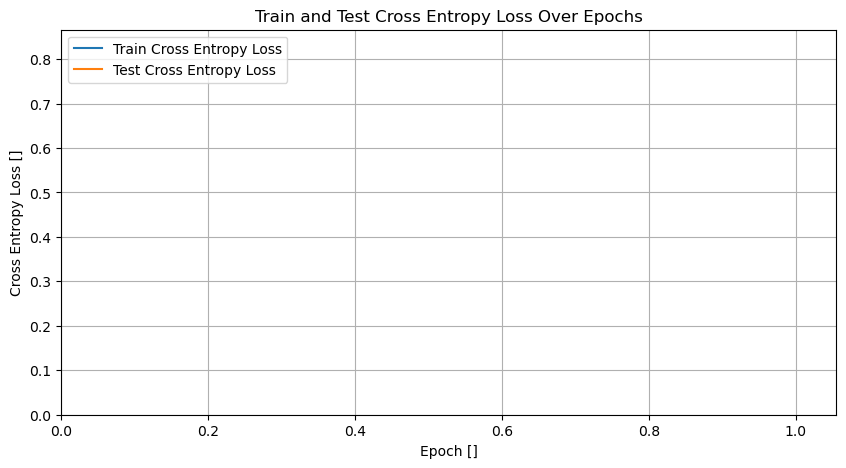

Epoch: 1
---------
Train Loss of [Batch 0/385]: 0.7591
Train Loss of [Batch 100/385]: 0.7879
Train Loss of [Batch 200/385]: 0.7348
Train Loss of [Batch 300/385]: 0.8181

Train loss: 0.76546 | Train accuracy: 74.43%
Train Class-wise Loss: tensor([0.9109, 0.5723], device='cuda:0')

Test loss: 0.71159 | Test accuracy: 71.97%
Test Class-wise Loss: tensor([1.0449, 0.4112], device='cuda:0')



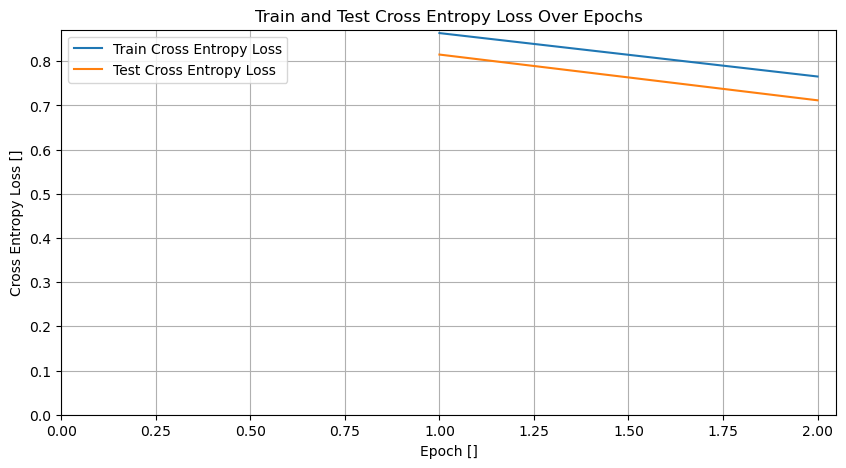

Epoch: 2
---------
Train Loss of [Batch 0/385]: 0.6188
Train Loss of [Batch 100/385]: 0.6740
Train Loss of [Batch 200/385]: 0.7783
Train Loss of [Batch 300/385]: 0.6993

Train loss: 0.69190 | Train accuracy: 76.26%
Train Class-wise Loss: tensor([0.8718, 0.4662], device='cuda:0')

Test loss: 0.63319 | Test accuracy: 74.28%
Test Class-wise Loss: tensor([1.0219, 0.3348], device='cuda:0')



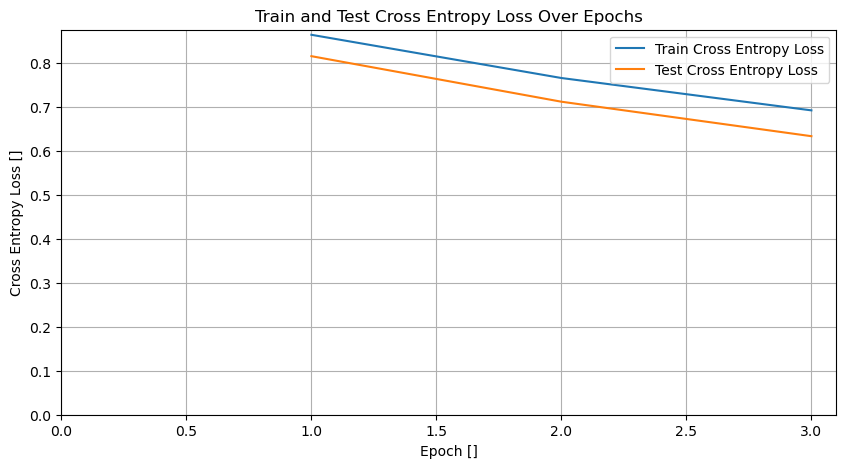

Epoch: 3
---------
Train Loss of [Batch 0/385]: 0.8384
Train Loss of [Batch 100/385]: 0.7229
Train Loss of [Batch 200/385]: 0.7996
Train Loss of [Batch 300/385]: 0.5549

Train loss: 0.65051 | Train accuracy: 78.27%
Train Class-wise Loss: tensor([0.8325, 0.4234], device='cuda:0')

Test loss: 0.58432 | Test accuracy: 75.27%
Test Class-wise Loss: tensor([0.9843, 0.2994], device='cuda:0')



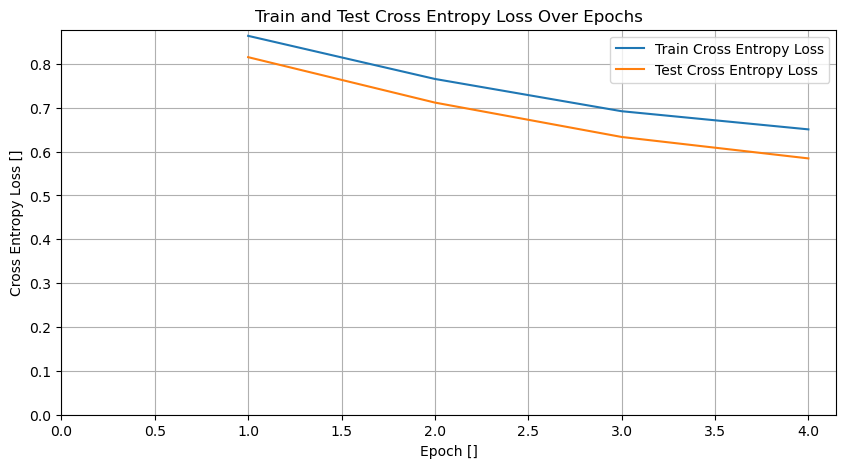

Epoch: 4
---------
Train Loss of [Batch 0/385]: 0.6643
Train Loss of [Batch 100/385]: 0.7843
Train Loss of [Batch 200/385]: 0.6006
Train Loss of [Batch 300/385]: 0.6405

Train loss: 0.61374 | Train accuracy: 80.36%
Train Class-wise Loss: tensor([0.7933, 0.3848], device='cuda:0')

Test loss: 0.55375 | Test accuracy: 76.92%
Test Class-wise Loss: tensor([0.9708, 0.2729], device='cuda:0')



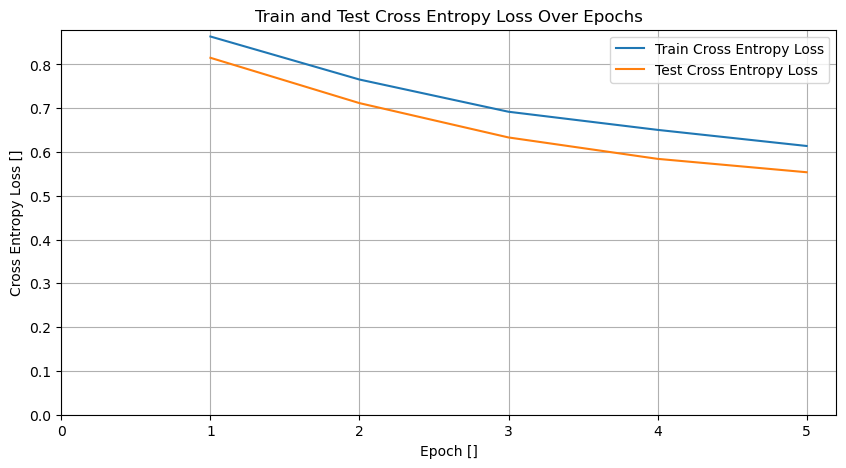

Epoch: 5
---------
Train Loss of [Batch 0/385]: 0.5675
Train Loss of [Batch 100/385]: 0.5125
Train Loss of [Batch 200/385]: 0.4488
Train Loss of [Batch 300/385]: 0.7163

Train loss: 0.58684 | Train accuracy: 82.04%
Train Class-wise Loss: tensor([0.7609, 0.3660], device='cuda:0')

Test loss: 0.53146 | Test accuracy: 77.70%
Test Class-wise Loss: tensor([0.9660, 0.2442], device='cuda:0')



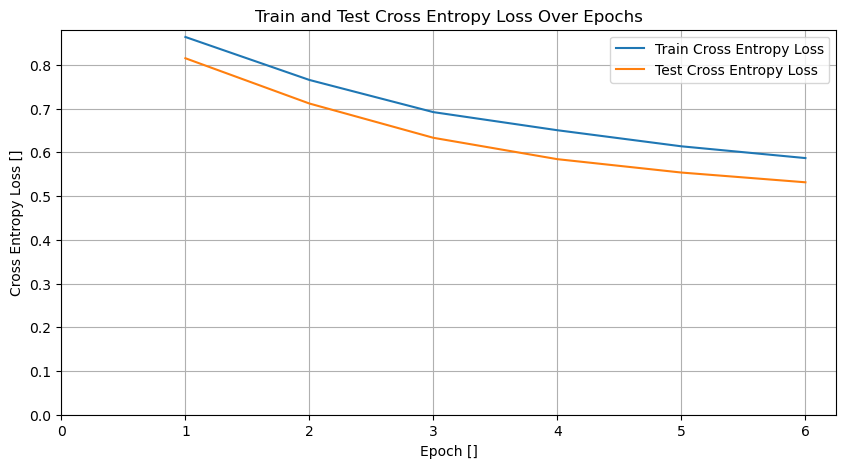

Epoch: 6
---------
Train Loss of [Batch 0/385]: 0.7065
Train Loss of [Batch 100/385]: 0.5183
Train Loss of [Batch 200/385]: 0.5265
Train Loss of [Batch 300/385]: 0.4749

Train loss: 0.56632 | Train accuracy: 83.68%
Train Class-wise Loss: tensor([0.7248, 0.3650], device='cuda:0')

Test loss: 0.49154 | Test accuracy: 80.54%
Test Class-wise Loss: tensor([0.8508, 0.2591], device='cuda:0')



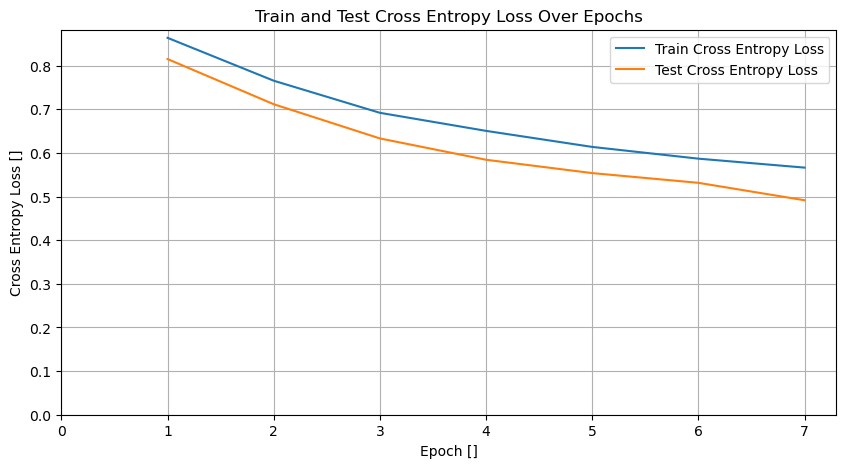

Epoch: 7
---------
Train Loss of [Batch 0/385]: 0.6430
Train Loss of [Batch 100/385]: 0.7162
Train Loss of [Batch 200/385]: 0.5752
Train Loss of [Batch 300/385]: 0.5916

Train loss: 0.54652 | Train accuracy: 85.15%
Train Class-wise Loss: tensor([0.6919, 0.3616], device='cuda:0')

Test loss: 0.46513 | Test accuracy: 83.07%
Test Class-wise Loss: tensor([0.7593, 0.2848], device='cuda:0')



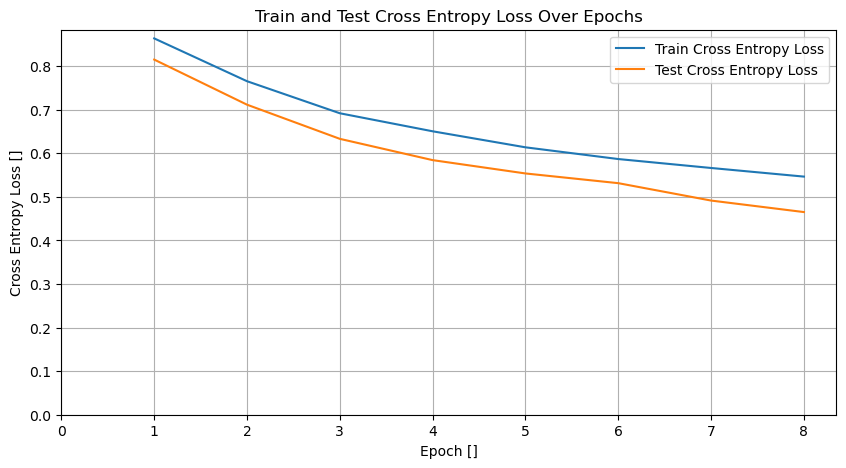

Epoch: 8
---------
Train Loss of [Batch 0/385]: 0.5337
Train Loss of [Batch 100/385]: 0.4001
Train Loss of [Batch 200/385]: 0.6168
Train Loss of [Batch 300/385]: 0.3991

Train loss: 0.52694 | Train accuracy: 86.25%
Train Class-wise Loss: tensor([0.6619, 0.3627], device='cuda:0')

Test loss: 0.45187 | Test accuracy: 81.70%
Test Class-wise Loss: tensor([0.8028, 0.2352], device='cuda:0')



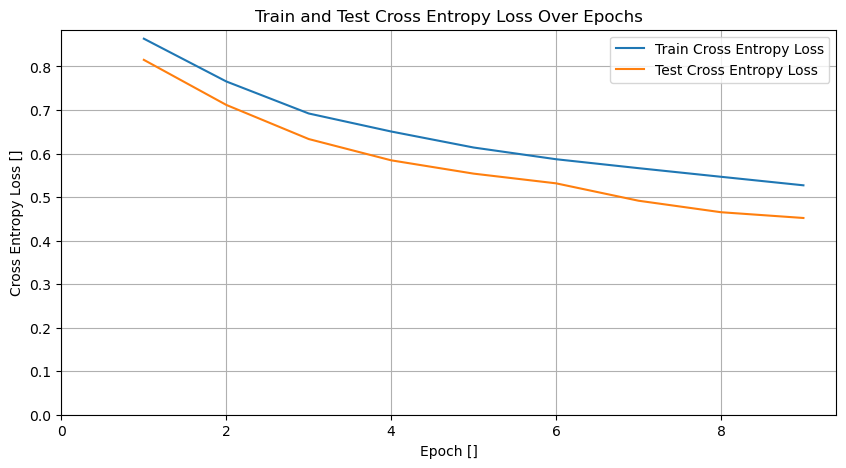

Epoch: 9
---------
Train Loss of [Batch 0/385]: 0.4728
Train Loss of [Batch 100/385]: 0.5259
Train Loss of [Batch 200/385]: 0.4814
Train Loss of [Batch 300/385]: 0.5816

Train loss: 0.51017 | Train accuracy: 87.25%
Train Class-wise Loss: tensor([0.6313, 0.3621], device='cuda:0')

Test loss: 0.43159 | Test accuracy: 82.99%
Test Class-wise Loss: tensor([0.7527, 0.2441], device='cuda:0')



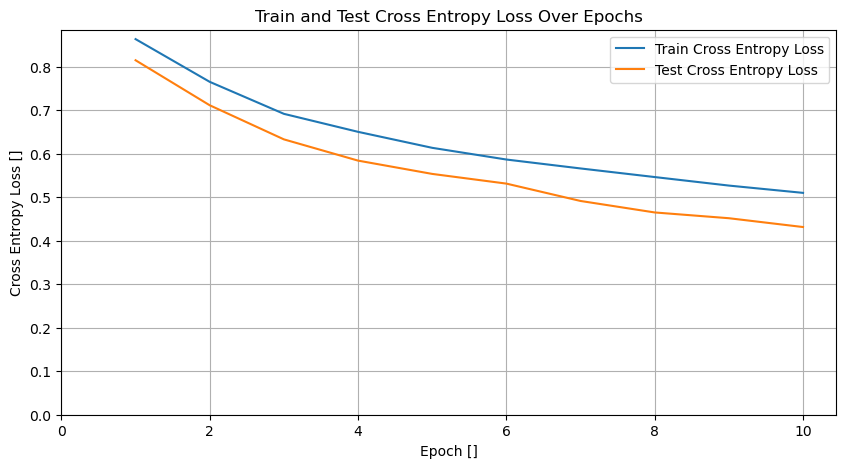

Epoch: 10
---------
Train Loss of [Batch 0/385]: 0.5687
Train Loss of [Batch 100/385]: 0.5359
Train Loss of [Batch 200/385]: 0.5547
Train Loss of [Batch 300/385]: 0.5370

Train loss: 0.48822 | Train accuracy: 87.80%
Train Class-wise Loss: tensor([0.6065, 0.3405], device='cuda:0')

Test loss: 0.42119 | Test accuracy: 82.38%
Test Class-wise Loss: tensor([0.7589, 0.2214], device='cuda:0')



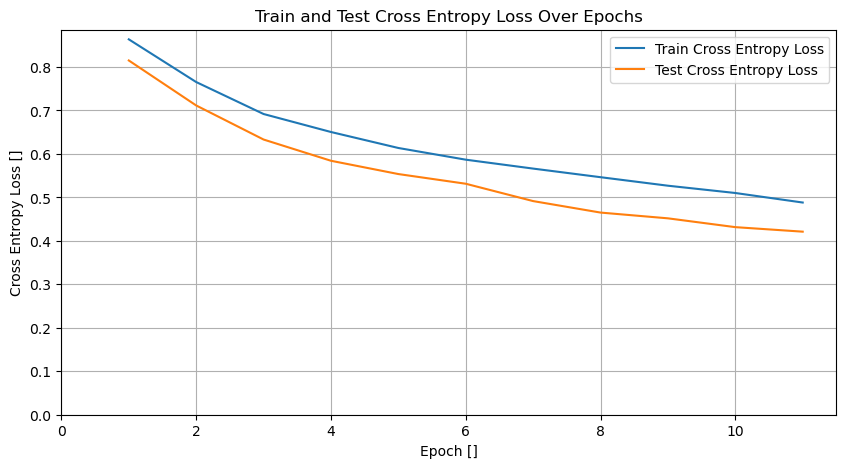

Epoch: 11
---------
Train Loss of [Batch 0/385]: 0.4624
Train Loss of [Batch 100/385]: 0.3878
Train Loss of [Batch 200/385]: 0.5321
Train Loss of [Batch 300/385]: 0.5142

Train loss: 0.48138 | Train accuracy: 88.44%
Train Class-wise Loss: tensor([0.5803, 0.3578], device='cuda:0')

Test loss: 0.39278 | Test accuracy: 86.03%
Test Class-wise Loss: tensor([0.6252, 0.2762], device='cuda:0')



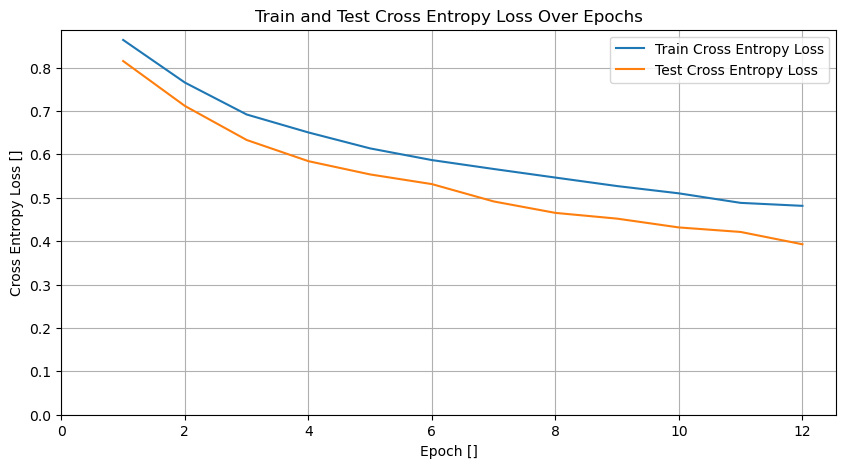

Epoch: 12
---------
Train Loss of [Batch 0/385]: 0.3843
Train Loss of [Batch 100/385]: 0.5184
Train Loss of [Batch 200/385]: 0.6318
Train Loss of [Batch 300/385]: 0.4698

Train loss: 0.45996 | Train accuracy: 88.60%
Train Class-wise Loss: tensor([0.5623, 0.3330], device='cuda:0')

Test loss: 0.39130 | Test accuracy: 83.44%
Test Class-wise Loss: tensor([0.6805, 0.2320], device='cuda:0')



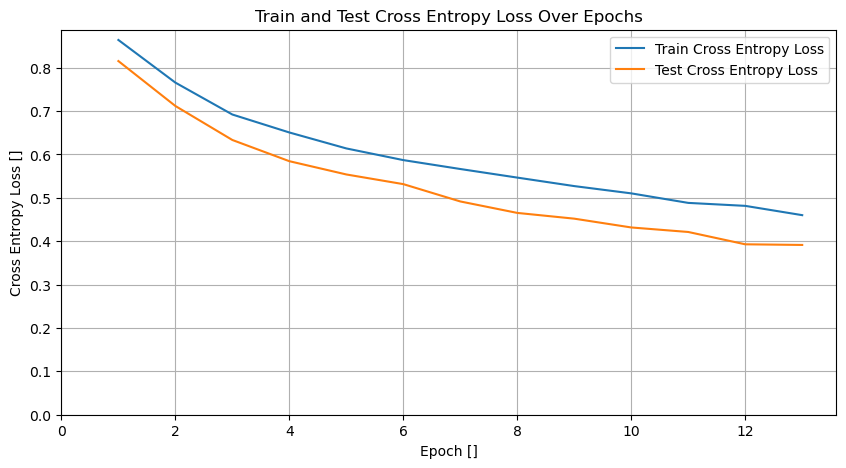

Epoch: 13
---------
Train Loss of [Batch 0/385]: 0.5279
Train Loss of [Batch 100/385]: 0.5228
Train Loss of [Batch 200/385]: 0.5608
Train Loss of [Batch 300/385]: 0.4012

Train loss: 0.44997 | Train accuracy: 88.98%
Train Class-wise Loss: tensor([0.5407, 0.3409], device='cuda:0')

Test loss: 0.37359 | Test accuracy: 84.80%
Test Class-wise Loss: tensor([0.6275, 0.2426], device='cuda:0')



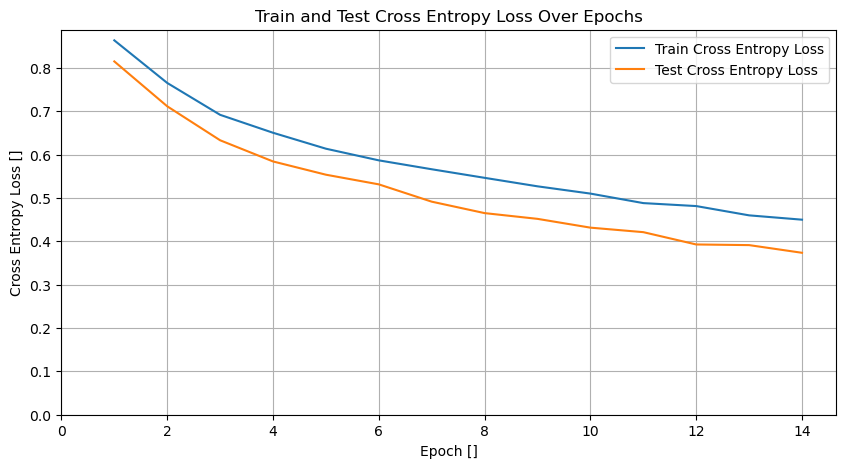

Epoch: 14
---------
Train Loss of [Batch 0/385]: 0.4490
Train Loss of [Batch 100/385]: 0.5426
Train Loss of [Batch 200/385]: 0.4407
Train Loss of [Batch 300/385]: 0.5000

Train loss: 0.44248 | Train accuracy: 89.20%
Train Class-wise Loss: tensor([0.5226, 0.3396], device='cuda:0')

Test loss: 0.36408 | Test accuracy: 85.26%
Test Class-wise Loss: tensor([0.6071, 0.2424], device='cuda:0')



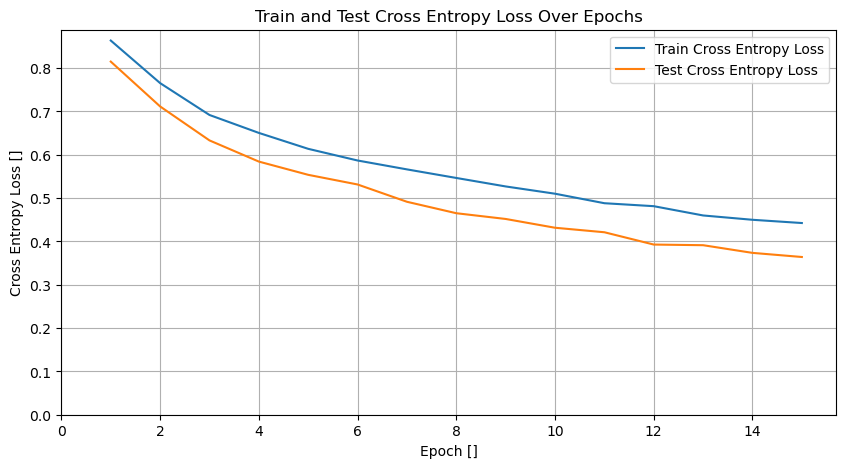

Epoch: 15
---------
Train Loss of [Batch 0/385]: 0.4441
Train Loss of [Batch 100/385]: 0.4673
Train Loss of [Batch 200/385]: 0.4856
Train Loss of [Batch 300/385]: 0.4425

Train loss: 0.42950 | Train accuracy: 89.48%
Train Class-wise Loss: tensor([0.5041, 0.3354], device='cuda:0')

Test loss: 0.35672 | Test accuracy: 84.74%
Test Class-wise Loss: tensor([0.6051, 0.2361], device='cuda:0')



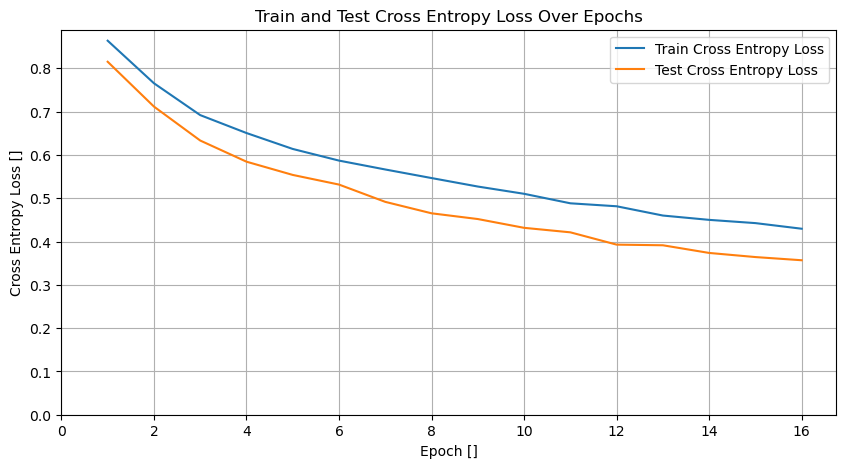

Epoch: 16
---------
Train Loss of [Batch 0/385]: 0.5194
Train Loss of [Batch 100/385]: 0.5032
Train Loss of [Batch 200/385]: 0.4895
Train Loss of [Batch 300/385]: 0.4259

Train loss: 0.42114 | Train accuracy: 89.32%
Train Class-wise Loss: tensor([0.4916, 0.3345], device='cuda:0')

Test loss: 0.35043 | Test accuracy: 84.17%
Test Class-wise Loss: tensor([0.6061, 0.2305], device='cuda:0')



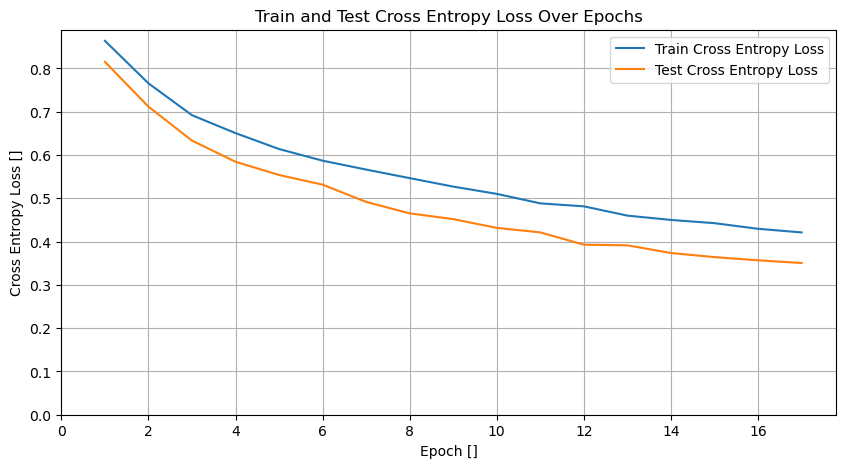

Epoch: 17
---------
Train Loss of [Batch 0/385]: 0.4335
Train Loss of [Batch 100/385]: 0.3540
Train Loss of [Batch 200/385]: 0.4513
Train Loss of [Batch 300/385]: 0.4134

Train loss: 0.41610 | Train accuracy: 89.65%
Train Class-wise Loss: tensor([0.4752, 0.3446], device='cuda:0')

Test loss: 0.34549 | Test accuracy: 83.98%
Test Class-wise Loss: tensor([0.6145, 0.2130], device='cuda:0')



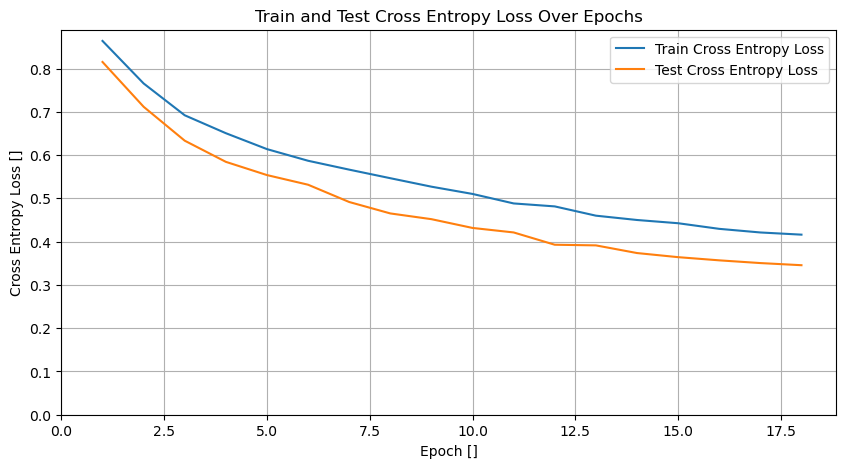

Epoch: 18
---------
Train Loss of [Batch 0/385]: 0.3682
Train Loss of [Batch 100/385]: 0.3490
Train Loss of [Batch 200/385]: 0.3282
Train Loss of [Batch 300/385]: 0.3473

Train loss: 0.40694 | Train accuracy: 89.61%
Train Class-wise Loss: tensor([0.4622, 0.3390], device='cuda:0')

Test loss: 0.33260 | Test accuracy: 85.41%
Test Class-wise Loss: tensor([0.5497, 0.2441], device='cuda:0')



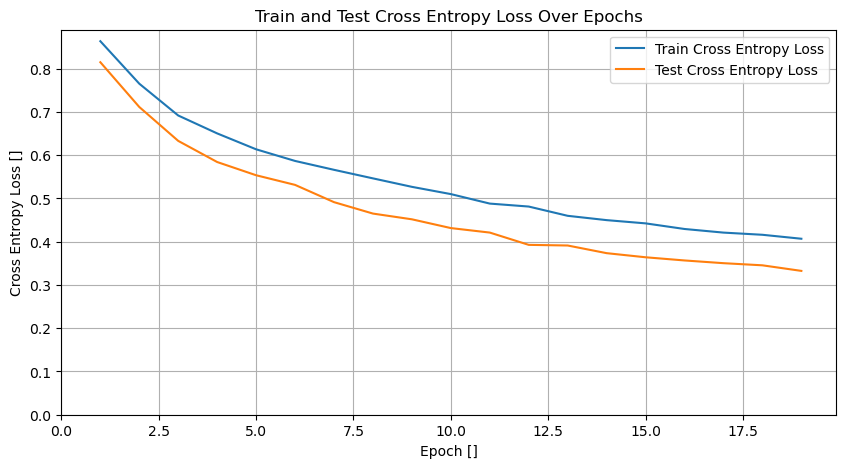

Epoch: 19
---------
Train Loss of [Batch 0/385]: 0.5009
Train Loss of [Batch 100/385]: 0.3986
Train Loss of [Batch 200/385]: 0.3652
Train Loss of [Batch 300/385]: 0.4343

Train loss: 0.40051 | Train accuracy: 89.64%
Train Class-wise Loss: tensor([0.4503, 0.3510], device='cuda:0')

Test loss: 0.33033 | Test accuracy: 85.31%
Test Class-wise Loss: tensor([0.5330, 0.2496], device='cuda:0')



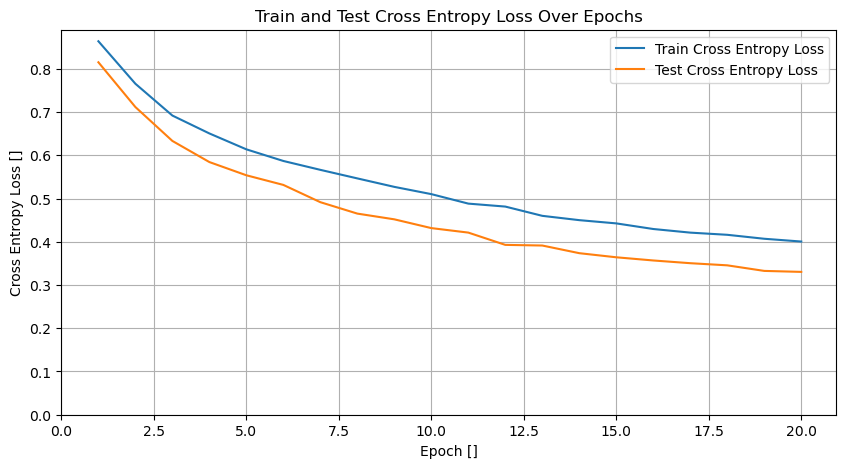

Epoch: 20
---------
Train Loss of [Batch 0/385]: 0.3041
Train Loss of [Batch 100/385]: 0.3302
Train Loss of [Batch 200/385]: 0.4554
Train Loss of [Batch 300/385]: 0.4368

Train loss: 0.38863 | Train accuracy: 89.69%
Train Class-wise Loss: tensor([0.4410, 0.3293], device='cuda:0')

Test loss: 0.32743 | Test accuracy: 83.86%
Test Class-wise Loss: tensor([0.5720, 0.2146], device='cuda:0')



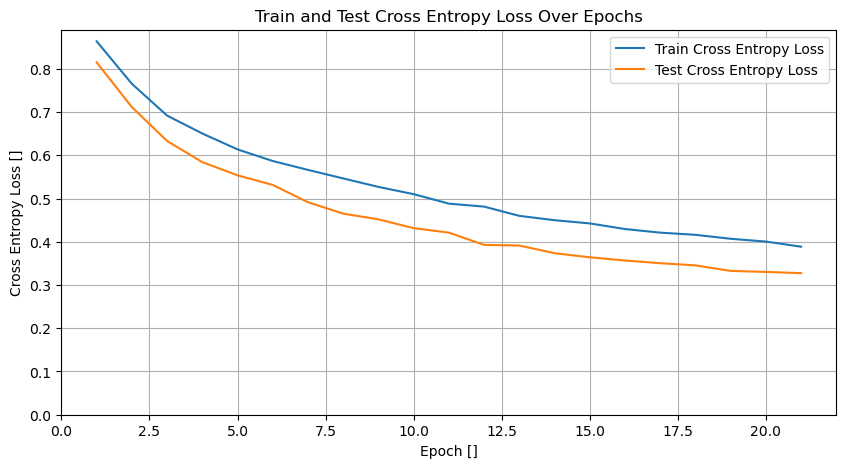

Epoch: 21
---------
Train Loss of [Batch 0/385]: 0.4180
Train Loss of [Batch 100/385]: 0.3558
Train Loss of [Batch 200/385]: 0.3080
Train Loss of [Batch 300/385]: 0.4033

Train loss: 0.38867 | Train accuracy: 89.69%
Train Class-wise Loss: tensor([0.4319, 0.3369], device='cuda:0')

Test loss: 0.32256 | Test accuracy: 84.57%
Test Class-wise Loss: tensor([0.5338, 0.2383], device='cuda:0')



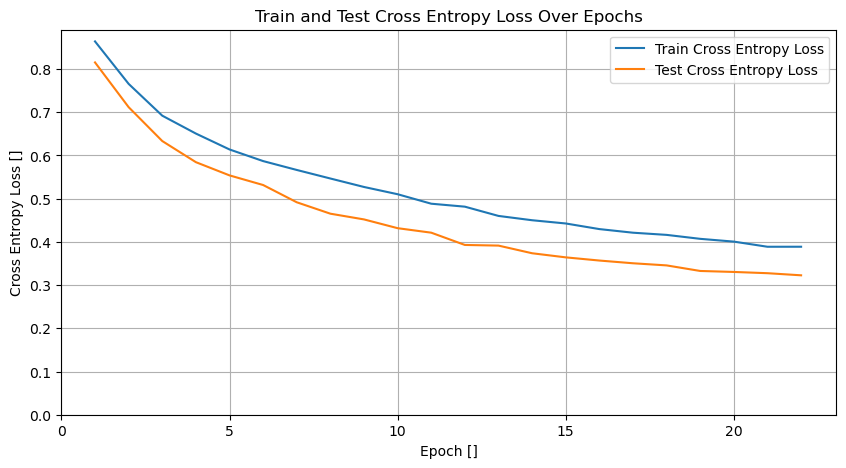

Epoch: 22
---------
Train Loss of [Batch 0/385]: 0.3000
Train Loss of [Batch 100/385]: 0.3952
Train Loss of [Batch 200/385]: 0.2784
Train Loss of [Batch 300/385]: 0.4299

Train loss: 0.38048 | Train accuracy: 89.97%
Train Class-wise Loss: tensor([0.4206, 0.3292], device='cuda:0')

Test loss: 0.31698 | Test accuracy: 84.64%
Test Class-wise Loss: tensor([0.5266, 0.2316], device='cuda:0')



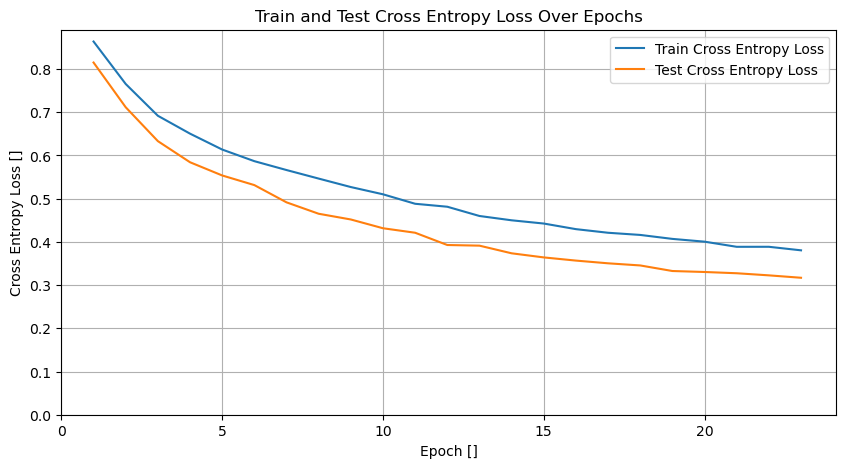

Epoch: 23
---------
Train Loss of [Batch 0/385]: 0.4359
Train Loss of [Batch 100/385]: 0.2932
Train Loss of [Batch 200/385]: 0.3923
Train Loss of [Batch 300/385]: 0.4281

Train loss: 0.38013 | Train accuracy: 89.89%
Train Class-wise Loss: tensor([0.4128, 0.3470], device='cuda:0')

Test loss: 0.31776 | Test accuracy: 83.05%
Test Class-wise Loss: tensor([0.5585, 0.2071], device='cuda:0')



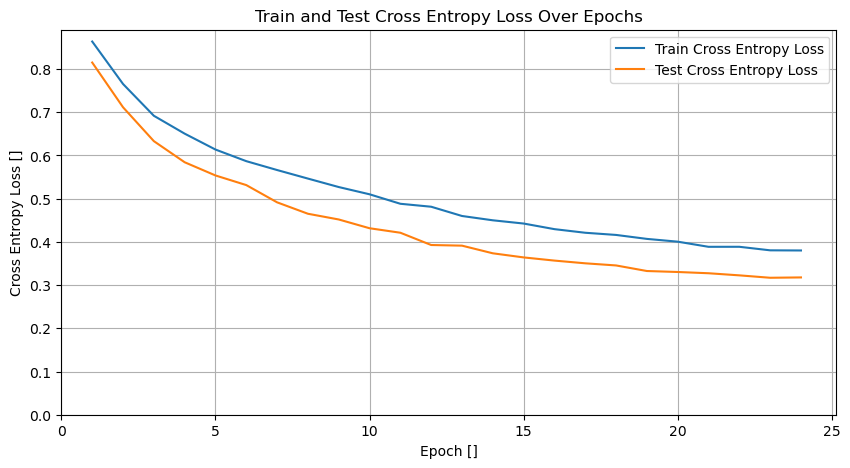

Epoch: 24
---------
Train Loss of [Batch 0/385]: 0.3965
Train Loss of [Batch 100/385]: 0.3630
Train Loss of [Batch 200/385]: 0.4340
Train Loss of [Batch 300/385]: 0.3521

Train loss: 0.37025 | Train accuracy: 90.01%
Train Class-wise Loss: tensor([0.4048, 0.3349], device='cuda:0')

Test loss: 0.31176 | Test accuracy: 84.19%
Test Class-wise Loss: tensor([0.5290, 0.2283], device='cuda:0')



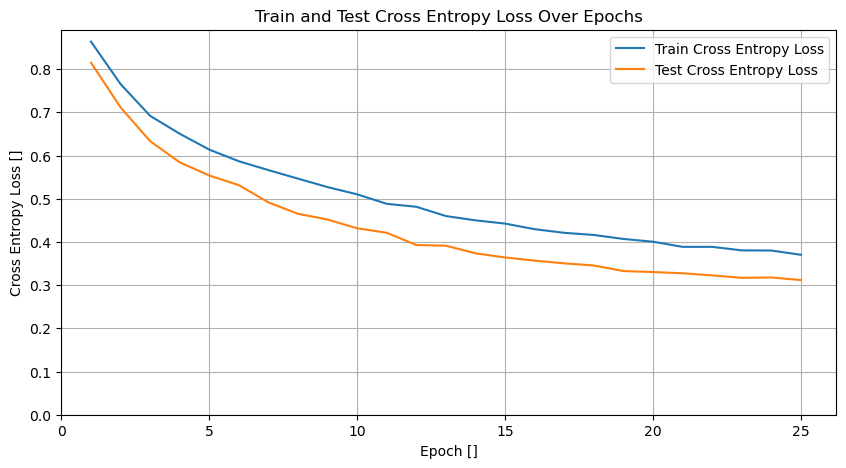

Epoch: 25
---------
Train Loss of [Batch 0/385]: 0.3967
Train Loss of [Batch 100/385]: 0.3660
Train Loss of [Batch 200/385]: 0.3716
Train Loss of [Batch 300/385]: 0.3105

Train loss: 0.36628 | Train accuracy: 89.97%
Train Class-wise Loss: tensor([0.3973, 0.3314], device='cuda:0')

Test loss: 0.30722 | Test accuracy: 83.66%
Test Class-wise Loss: tensor([0.5317, 0.2161], device='cuda:0')



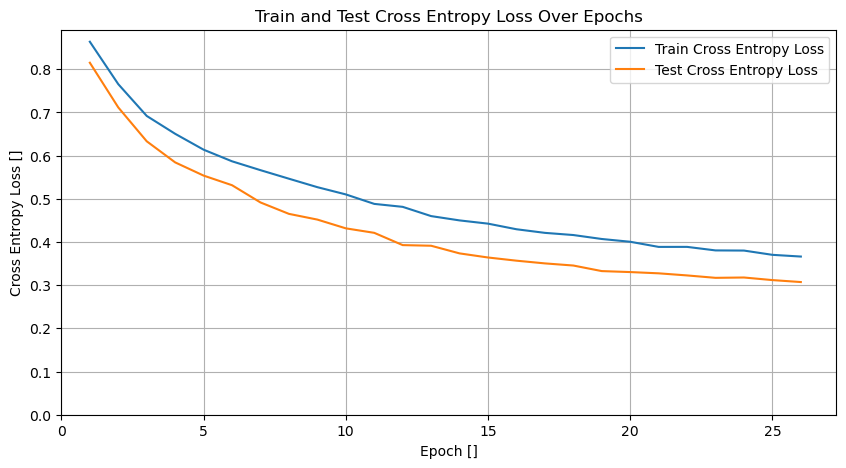

Epoch: 26
---------
Train Loss of [Batch 0/385]: 0.4058
Train Loss of [Batch 100/385]: 0.2769
Train Loss of [Batch 200/385]: 0.4860
Train Loss of [Batch 300/385]: 0.3826

Train loss: 0.36337 | Train accuracy: 89.95%
Train Class-wise Loss: tensor([0.3901, 0.3336], device='cuda:0')

Test loss: 0.30266 | Test accuracy: 84.53%
Test Class-wise Loss: tensor([0.4993, 0.2346], device='cuda:0')



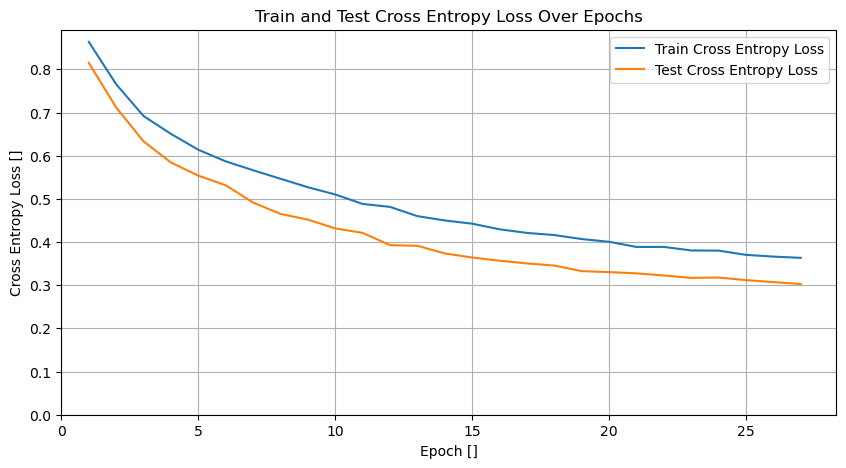

Epoch: 27
---------
Train Loss of [Batch 0/385]: 0.4350
Train Loss of [Batch 100/385]: 0.4074
Train Loss of [Batch 200/385]: 0.4138
Train Loss of [Batch 300/385]: 0.4034

Train loss: 0.36170 | Train accuracy: 90.11%
Train Class-wise Loss: tensor([0.3821, 0.3451], device='cuda:0')

Test loss: 0.29610 | Test accuracy: 84.76%
Test Class-wise Loss: tensor([0.4921, 0.2321], device='cuda:0')



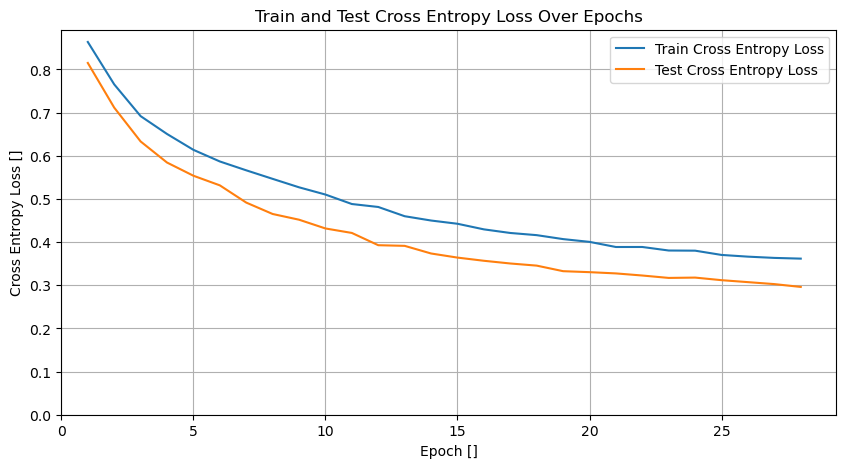

Epoch: 28
---------
Train Loss of [Batch 0/385]: 0.4497
Train Loss of [Batch 100/385]: 0.3281
Train Loss of [Batch 200/385]: 0.4194
Train Loss of [Batch 300/385]: 0.2989

Train loss: 0.35643 | Train accuracy: 90.12%
Train Class-wise Loss: tensor([0.3767, 0.3404], device='cuda:0')

Test loss: 0.29391 | Test accuracy: 85.29%
Test Class-wise Loss: tensor([0.4697, 0.2438], device='cuda:0')



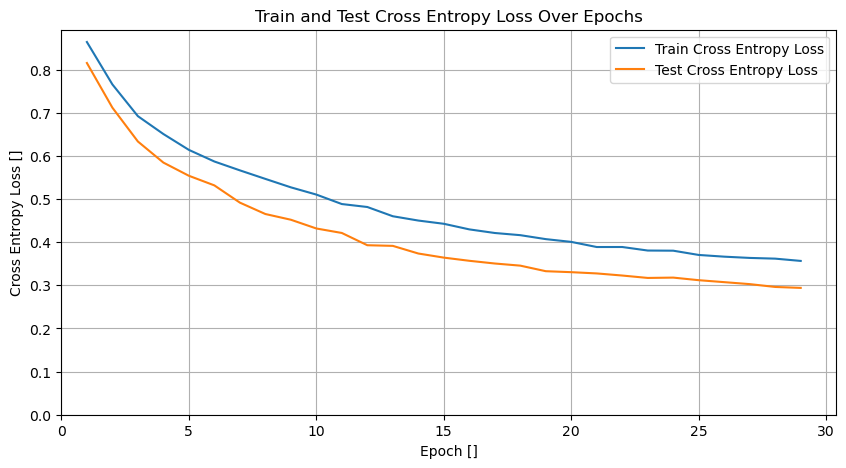

Epoch: 29
---------
Train Loss of [Batch 0/385]: 0.3611
Train Loss of [Batch 100/385]: 0.2836
Train Loss of [Batch 200/385]: 0.3514
Train Loss of [Batch 300/385]: 0.2953

Train loss: 0.35310 | Train accuracy: 90.21%
Train Class-wise Loss: tensor([0.3691, 0.3296], device='cuda:0')

Test loss: 0.29298 | Test accuracy: 84.35%
Test Class-wise Loss: tensor([0.4888, 0.2285], device='cuda:0')



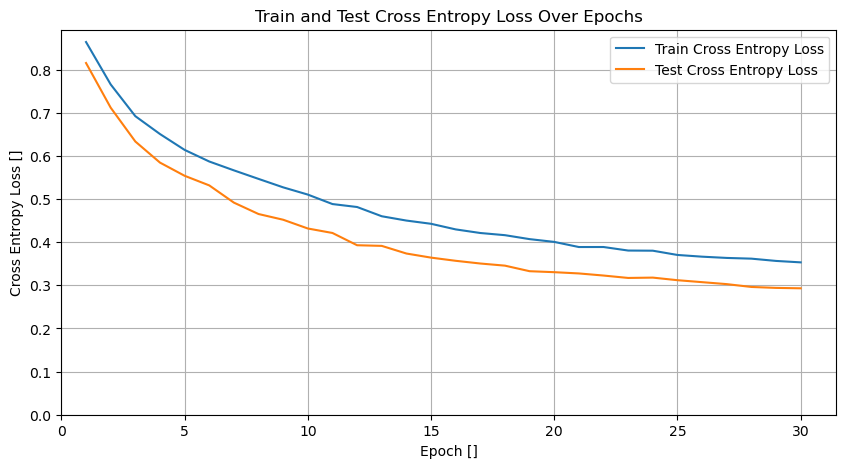

Epoch: 30
---------
Train Loss of [Batch 0/385]: 0.4060
Train Loss of [Batch 100/385]: 0.2378
Train Loss of [Batch 200/385]: 0.6083
Train Loss of [Batch 300/385]: 0.3266

Train loss: 0.34824 | Train accuracy: 90.18%
Train Class-wise Loss: tensor([0.3659, 0.3310], device='cuda:0')

Test loss: 0.28950 | Test accuracy: 85.41%
Test Class-wise Loss: tensor([0.4636, 0.2377], device='cuda:0')



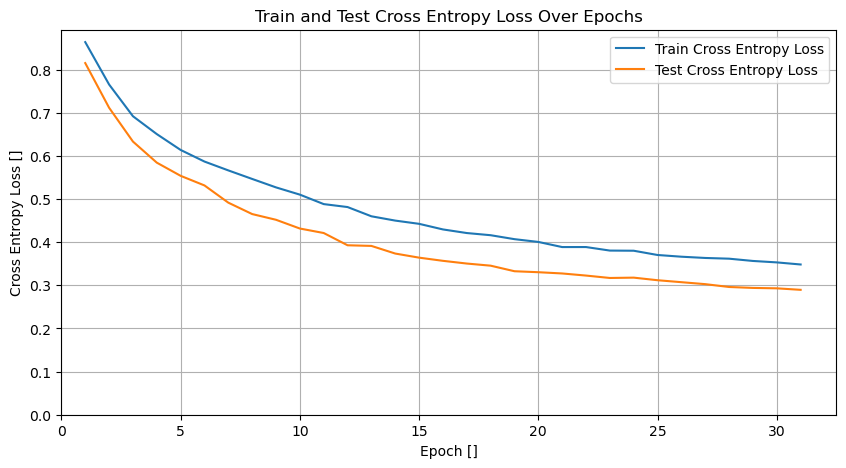

Epoch: 31
---------
Train Loss of [Batch 0/385]: 0.3649
Train Loss of [Batch 100/385]: 0.3583
Train Loss of [Batch 200/385]: 0.3331
Train Loss of [Batch 300/385]: 0.2953

Train loss: 0.34503 | Train accuracy: 90.28%
Train Class-wise Loss: tensor([0.3615, 0.3308], device='cuda:0')

Test loss: 0.28795 | Test accuracy: 84.22%
Test Class-wise Loss: tensor([0.4846, 0.2195], device='cuda:0')



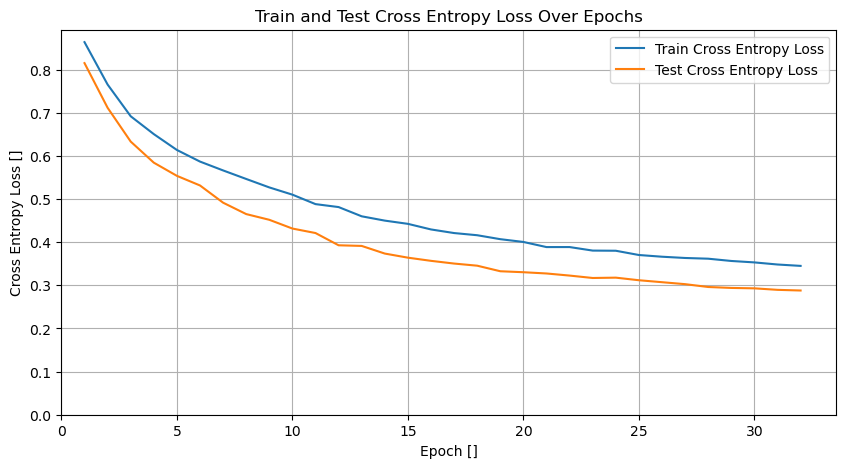

Epoch: 32
---------
Train Loss of [Batch 0/385]: 0.4072
Train Loss of [Batch 100/385]: 0.3691
Train Loss of [Batch 200/385]: 0.4541
Train Loss of [Batch 300/385]: 0.3543

Train loss: 0.34743 | Train accuracy: 90.44%
Train Class-wise Loss: tensor([0.3534, 0.3595], device='cuda:0')

Test loss: 0.28218 | Test accuracy: 85.63%
Test Class-wise Loss: tensor([0.4439, 0.2436], device='cuda:0')



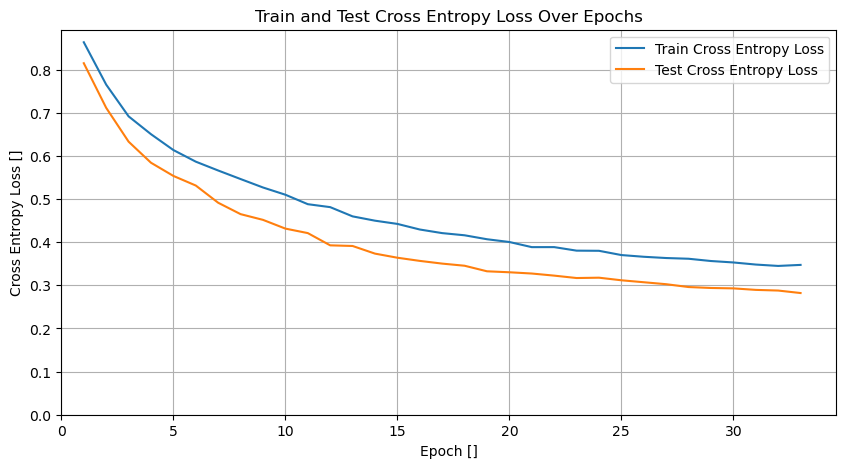

Epoch: 33
---------
Train Loss of [Batch 0/385]: 0.5224
Train Loss of [Batch 100/385]: 0.3799
Train Loss of [Batch 200/385]: 0.3794
Train Loss of [Batch 300/385]: 0.3474

Train loss: 0.33873 | Train accuracy: 90.47%
Train Class-wise Loss: tensor([0.3506, 0.3295], device='cuda:0')

Test loss: 0.27957 | Test accuracy: 85.32%
Test Class-wise Loss: tensor([0.4556, 0.2340], device='cuda:0')



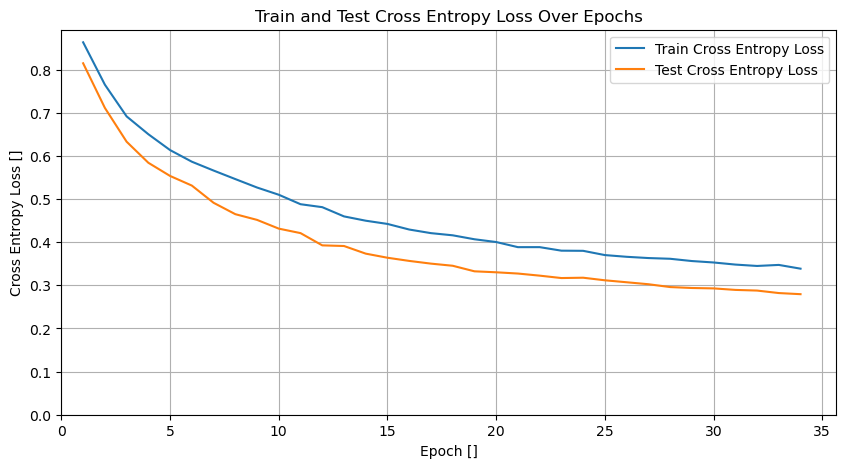

Epoch: 34
---------
Train Loss of [Batch 0/385]: 0.2626
Train Loss of [Batch 100/385]: 0.3023
Train Loss of [Batch 200/385]: 0.2502
Train Loss of [Batch 300/385]: 0.3660

Train loss: 0.33490 | Train accuracy: 90.39%
Train Class-wise Loss: tensor([0.3481, 0.3253], device='cuda:0')

Test loss: 0.27984 | Test accuracy: 85.13%
Test Class-wise Loss: tensor([0.4549, 0.2317], device='cuda:0')



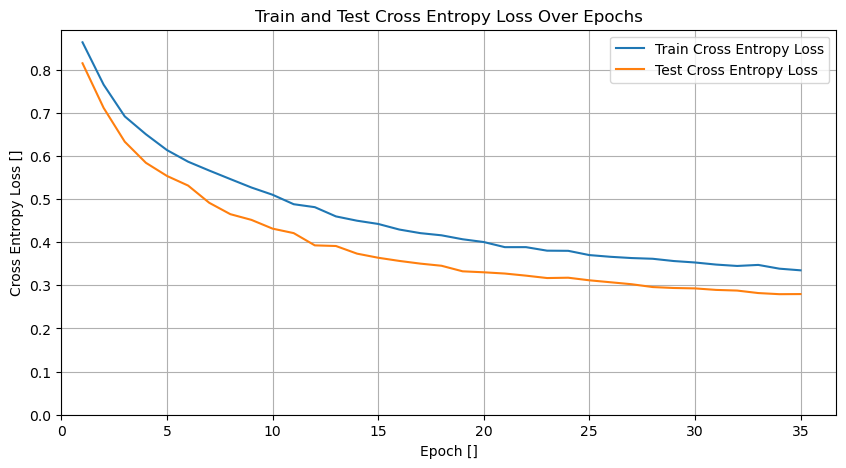

Epoch: 35
---------
Train Loss of [Batch 0/385]: 0.2730
Train Loss of [Batch 100/385]: 0.3727
Train Loss of [Batch 200/385]: 0.4115
Train Loss of [Batch 300/385]: 0.3083

Train loss: 0.33187 | Train accuracy: 90.68%
Train Class-wise Loss: tensor([0.3398, 0.3188], device='cuda:0')

Test loss: 0.27704 | Test accuracy: 85.95%
Test Class-wise Loss: tensor([0.4371, 0.2463], device='cuda:0')



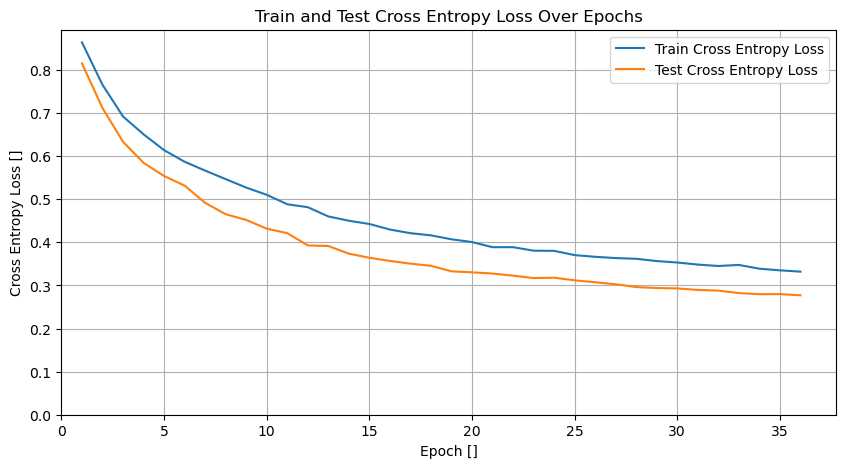

Epoch: 36
---------
Train Loss of [Batch 0/385]: 0.3074
Train Loss of [Batch 100/385]: 0.3084
Train Loss of [Batch 200/385]: 0.3154
Train Loss of [Batch 300/385]: 0.2754

Train loss: 0.33465 | Train accuracy: 90.91%
Train Class-wise Loss: tensor([0.3342, 0.3431], device='cuda:0')

Test loss: 0.28018 | Test accuracy: 84.38%
Test Class-wise Loss: tensor([0.4748, 0.2175], device='cuda:0')



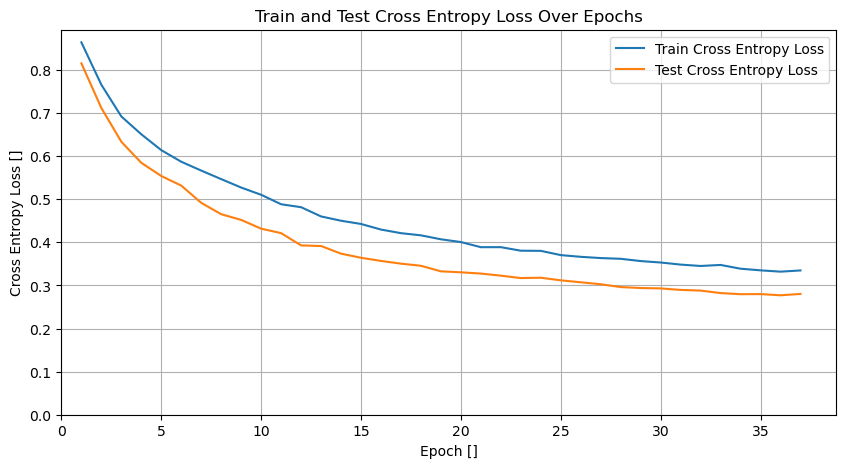

Epoch: 37
---------
Train Loss of [Batch 0/385]: 0.2394
Train Loss of [Batch 100/385]: 0.4032
Train Loss of [Batch 200/385]: 0.3194
Train Loss of [Batch 300/385]: 0.3273

Train loss: 0.33011 | Train accuracy: 90.80%
Train Class-wise Loss: tensor([0.3322, 0.3420], device='cuda:0')

Test loss: 0.26986 | Test accuracy: 86.97%
Test Class-wise Loss: tensor([0.4052, 0.2584], device='cuda:0')



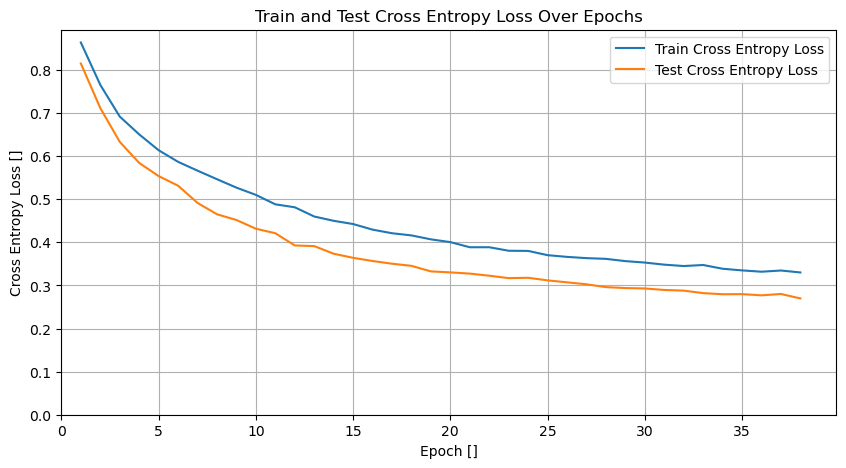

Epoch: 38
---------
Train Loss of [Batch 0/385]: 0.3115
Train Loss of [Batch 100/385]: 0.2411
Train Loss of [Batch 200/385]: 0.3285
Train Loss of [Batch 300/385]: 0.3286

Train loss: 0.32774 | Train accuracy: 90.96%
Train Class-wise Loss: tensor([0.3283, 0.3354], device='cuda:0')

Test loss: 0.26657 | Test accuracy: 87.32%
Test Class-wise Loss: tensor([0.3949, 0.2624], device='cuda:0')



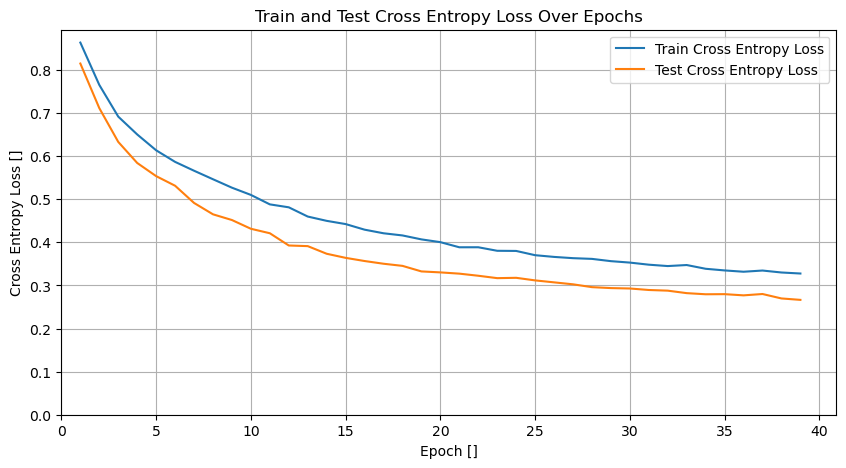

Epoch: 39
---------
Train Loss of [Batch 0/385]: 0.3096
Train Loss of [Batch 100/385]: 0.2126
Train Loss of [Batch 200/385]: 0.3265
Train Loss of [Batch 300/385]: 0.4304

Train loss: 0.32675 | Train accuracy: 90.83%
Train Class-wise Loss: tensor([0.3275, 0.3328], device='cuda:0')

Test loss: 0.27030 | Test accuracy: 85.12%
Test Class-wise Loss: tensor([0.4475, 0.2239], device='cuda:0')



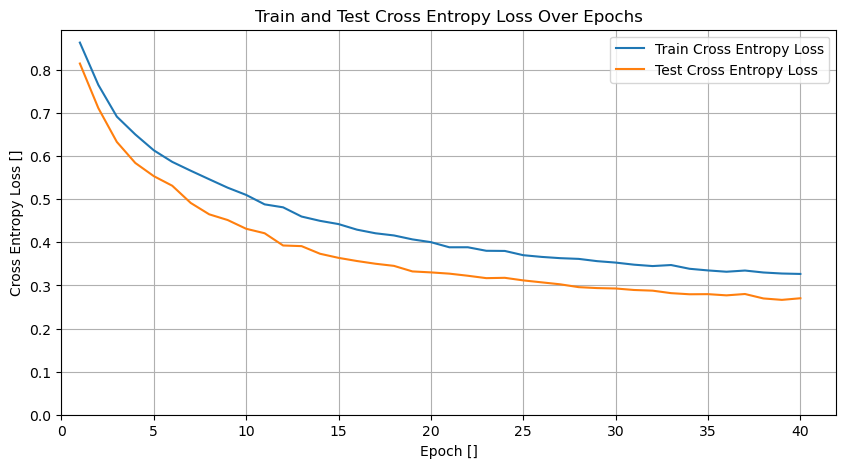

Epoch: 40
---------
Train Loss of [Batch 0/385]: 0.2093
Train Loss of [Batch 100/385]: 0.3442
Train Loss of [Batch 200/385]: 0.3114
Train Loss of [Batch 300/385]: 0.2568

Train loss: 0.32221 | Train accuracy: 91.02%
Train Class-wise Loss: tensor([0.3205, 0.3278], device='cuda:0')

Test loss: 0.26529 | Test accuracy: 86.93%
Test Class-wise Loss: tensor([0.3957, 0.2572], device='cuda:0')



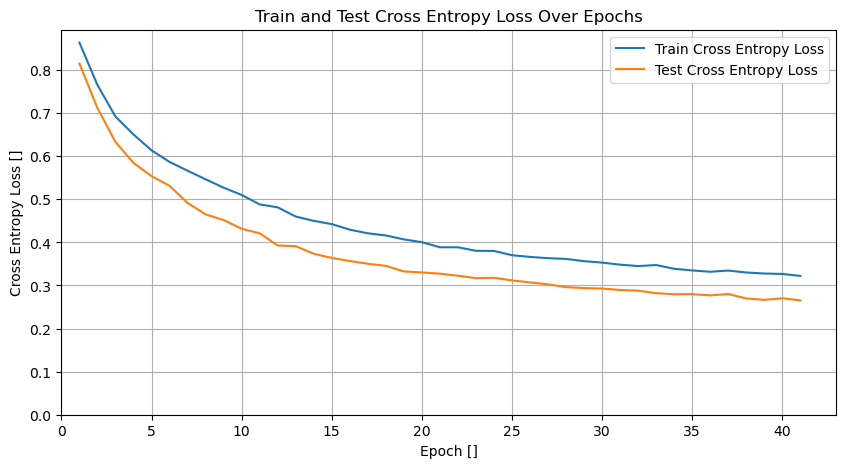

Epoch: 41
---------
Train Loss of [Batch 0/385]: 0.3149
Train Loss of [Batch 100/385]: 0.2606
Train Loss of [Batch 200/385]: 0.3220
Train Loss of [Batch 300/385]: 0.3845

Train loss: 0.31995 | Train accuracy: 90.99%
Train Class-wise Loss: tensor([0.3179, 0.3309], device='cuda:0')

Test loss: 0.26298 | Test accuracy: 86.98%
Test Class-wise Loss: tensor([0.3992, 0.2528], device='cuda:0')



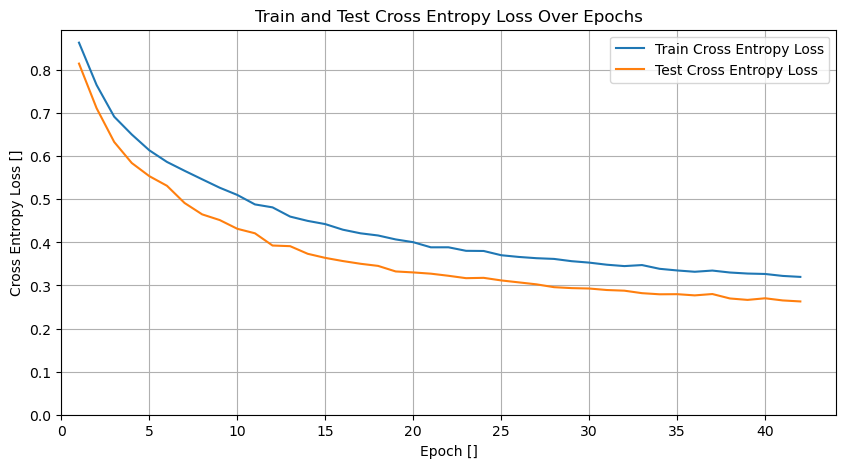

Epoch: 42
---------
Train Loss of [Batch 0/385]: 0.2567
Train Loss of [Batch 100/385]: 0.2455
Train Loss of [Batch 200/385]: 0.4131
Train Loss of [Batch 300/385]: 0.2862

Train loss: 0.32316 | Train accuracy: 90.99%
Train Class-wise Loss: tensor([0.3163, 0.3358], device='cuda:0')

Test loss: 0.26243 | Test accuracy: 86.54%
Test Class-wise Loss: tensor([0.4024, 0.2497], device='cuda:0')



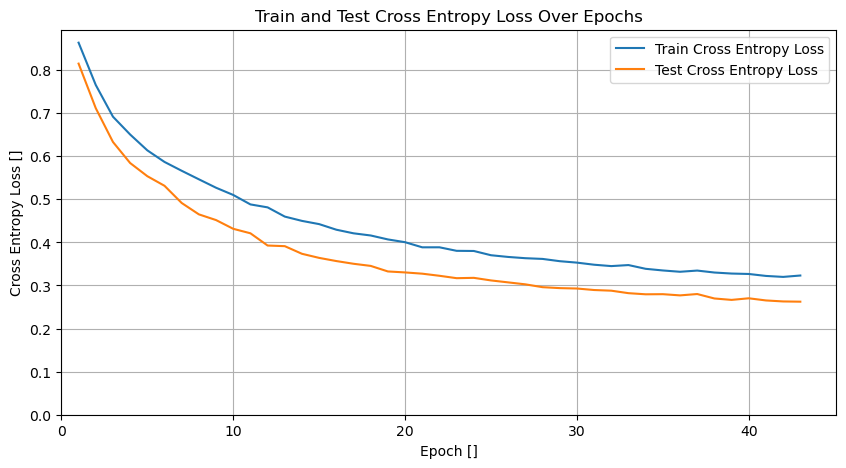

Epoch: 43
---------
Train Loss of [Batch 0/385]: 0.4427
Train Loss of [Batch 100/385]: 0.2732
Train Loss of [Batch 200/385]: 0.3760
Train Loss of [Batch 300/385]: 0.3668

Train loss: 0.31374 | Train accuracy: 91.15%
Train Class-wise Loss: tensor([0.3120, 0.3219], device='cuda:0')

Test loss: 0.26205 | Test accuracy: 87.13%
Test Class-wise Loss: tensor([0.3874, 0.2640], device='cuda:0')



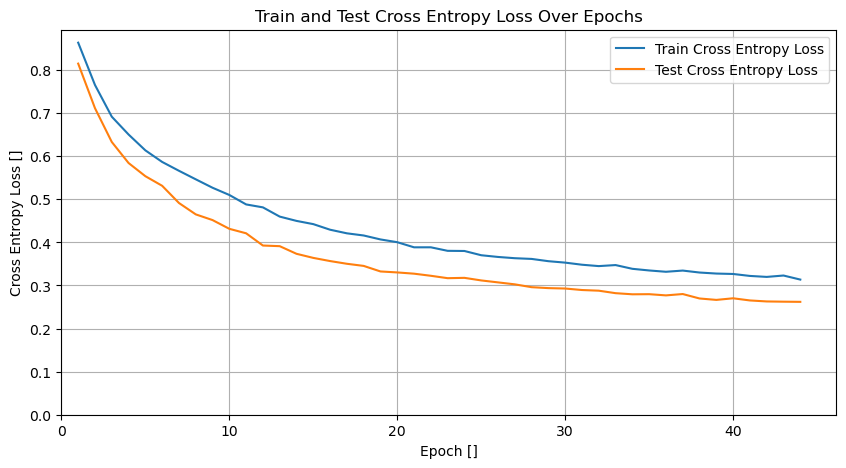

Epoch: 44
---------
Train Loss of [Batch 0/385]: 0.2849
Train Loss of [Batch 100/385]: 0.1957
Train Loss of [Batch 200/385]: 0.3032
Train Loss of [Batch 300/385]: 0.2682

Train loss: 0.31894 | Train accuracy: 91.09%
Train Class-wise Loss: tensor([0.3106, 0.3423], device='cuda:0')

Test loss: 0.25660 | Test accuracy: 87.13%
Test Class-wise Loss: tensor([0.3912, 0.2545], device='cuda:0')



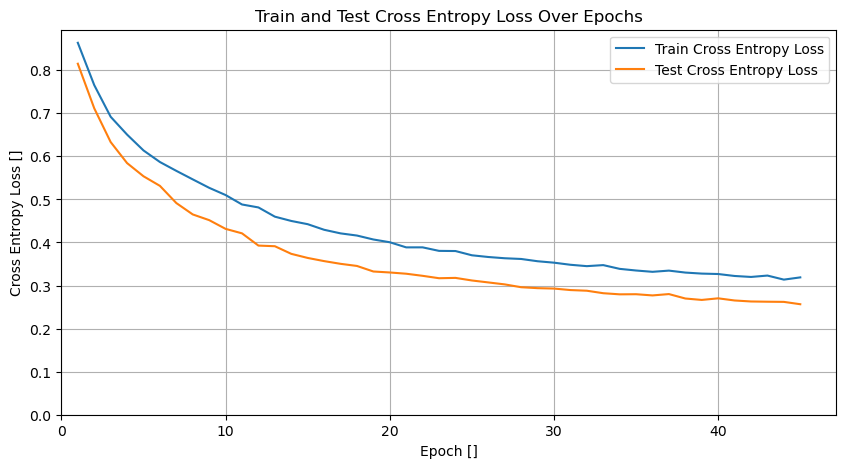

Epoch: 45
---------
Train Loss of [Batch 0/385]: 0.5332
Train Loss of [Batch 100/385]: 0.2761
Train Loss of [Batch 200/385]: 0.2236
Train Loss of [Batch 300/385]: 0.2750

Train loss: 0.31064 | Train accuracy: 91.16%
Train Class-wise Loss: tensor([0.3068, 0.3308], device='cuda:0')

Test loss: 0.25782 | Test accuracy: 86.82%
Test Class-wise Loss: tensor([0.3904, 0.2553], device='cuda:0')



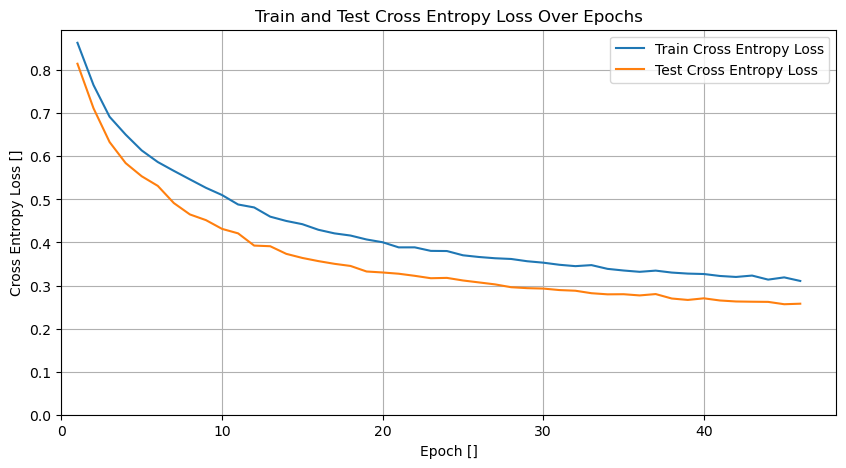

Epoch: 46
---------
Train Loss of [Batch 0/385]: 0.2718
Train Loss of [Batch 100/385]: 0.5489
Train Loss of [Batch 200/385]: 0.3998
Train Loss of [Batch 300/385]: 0.3467

Train loss: 0.31230 | Train accuracy: 91.11%
Train Class-wise Loss: tensor([0.3055, 0.3213], device='cuda:0')

Test loss: 0.25846 | Test accuracy: 86.60%
Test Class-wise Loss: tensor([0.3944, 0.2505], device='cuda:0')



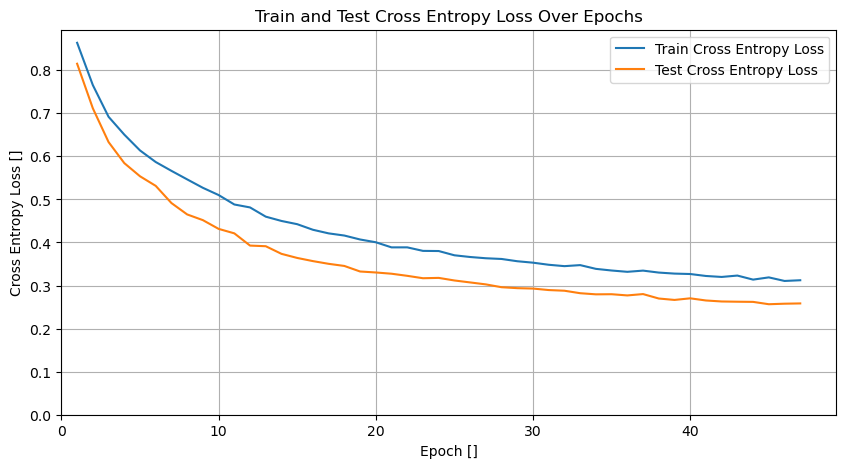

Epoch: 47
---------
Train Loss of [Batch 0/385]: 0.3360
Train Loss of [Batch 100/385]: 0.2447
Train Loss of [Batch 200/385]: 0.5617
Train Loss of [Batch 300/385]: 0.4297

Train loss: 0.31315 | Train accuracy: 91.35%
Train Class-wise Loss: tensor([0.2989, 0.3412], device='cuda:0')

Test loss: 0.25510 | Test accuracy: 88.45%
Test Class-wise Loss: tensor([0.3564, 0.2757], device='cuda:0')



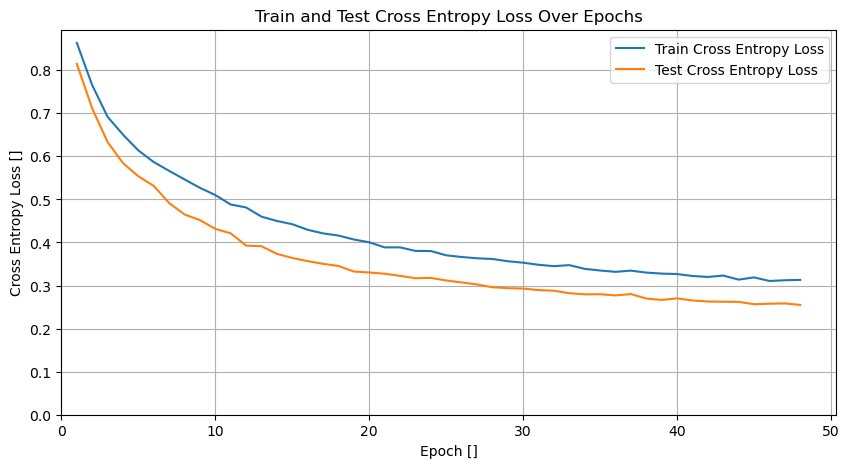

Epoch: 48
---------
Train Loss of [Batch 0/385]: 0.2328
Train Loss of [Batch 100/385]: 0.2408
Train Loss of [Batch 200/385]: 0.3678
Train Loss of [Batch 300/385]: 0.3331

Train loss: 0.30598 | Train accuracy: 91.26%
Train Class-wise Loss: tensor([0.3003, 0.3221], device='cuda:0')

Test loss: 0.25572 | Test accuracy: 86.55%
Test Class-wise Loss: tensor([0.3981, 0.2451], device='cuda:0')



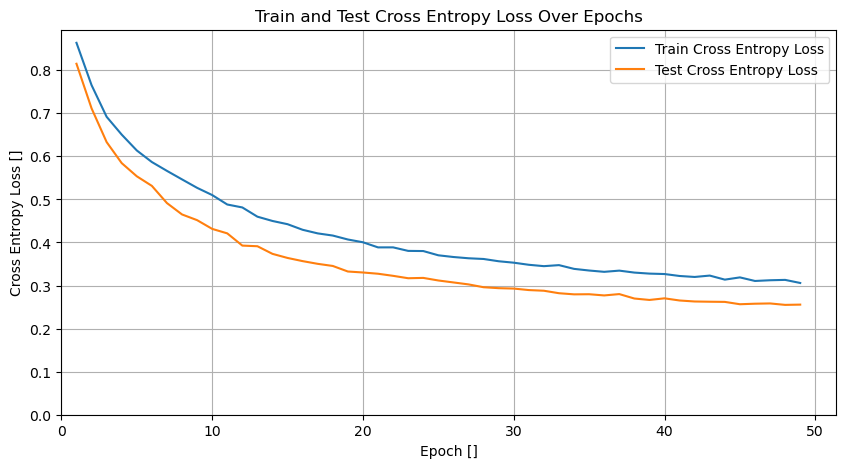

Epoch: 49
---------
Train Loss of [Batch 0/385]: 0.3414
Train Loss of [Batch 100/385]: 0.2440
Train Loss of [Batch 200/385]: 0.6130
Train Loss of [Batch 300/385]: 0.2810

Train loss: 0.30773 | Train accuracy: 91.50%
Train Class-wise Loss: tensor([0.2940, 0.3404], device='cuda:0')

Test loss: 0.25590 | Test accuracy: 86.98%
Test Class-wise Loss: tensor([0.3857, 0.2549], device='cuda:0')



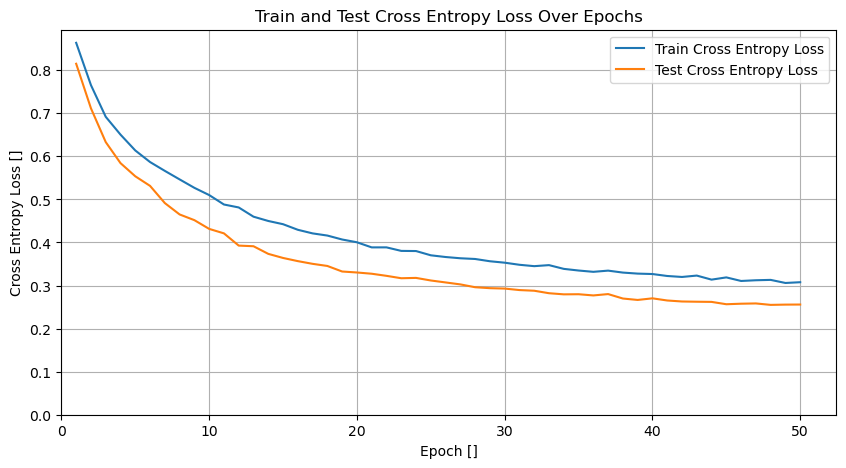

Train time on cuda: 9516.211 seconds


In [36]:
from tqdm.auto import tqdm

# Fix random seed for reproducibility
torch.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.cuda.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Learning rate:", configs_sc.HYPERPARAMETERS["learning_rate"])
print("Number of epochs:", configs_sc.HYPERPARAMETERS["epochs"])

# measure time with timing function
from timeit import default_timer as timer
start = timer()

# empty lists for storing of evaluation metrics
train_loss_progress = []
test_loss_progress = []
train_class_wise_losses = []
test_class_wise_losses = []

# epoch loop
for epoch in tqdm(range(configs_sc.HYPERPARAMETERS["epochs"])):
    print(f"Epoch: {epoch}\n---------") # print current epoch

    train_loss_epoch, train_class_wise_loss = train_utils.train_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    train_loss_progress.append({"epoch": epoch + 1, "train loss": train_loss_epoch})
    train_class_wise_losses.append(train_class_wise_loss.cpu().numpy())  # change to numpy for easier plotting

    test_loss_epoch, test_class_wise_loss = train_utils.test_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=test_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_loss_progress.append({"epoch": epoch + 1, "test loss": test_loss_epoch})
    test_class_wise_losses.append(test_class_wise_loss.cpu().numpy())


    # Clear output and update plot
    epochs = [entry["epoch"] for entry in train_loss_progress]
    train_losses = [entry["train loss"] for entry in train_loss_progress]
    test_losses = [entry["test loss"].cpu().item() for entry in test_loss_progress]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Train Cross Entropy Loss")
    plt.plot(epochs, test_losses, label="Test Cross Entropy Loss")
    plt.xlabel("Epoch []")
    plt.ylabel("Cross Entropy Loss []")
    plt.title("Train and Test Cross Entropy Loss Over Epochs")
    plt.xlim(left=0) # Force x-axis to start at epoch 0
    plt.ylim(bottom=0) # Force y-axis to start at 0
    plt.legend()
    plt.grid(True)
    plt.show()



end = timer()
train_utils.print_train_time(start, end, device)

### 4.3 Loss Curves

In [37]:
# try_epoch = 2 # ADJUSTABLE!
# Plot train class-wise loss of a specific epoch
# visualization_utils.plot_classwise_loss(try_epoch, train_class_wise_losses, configs_sc.HYPERPARAMETERS["num_classes"])

# Plot test class-wise loss of a specific epoch
# visualization_utils.plot_classwise_loss(try_epoch, test_class_wise_losses, configs_sc.HYPERPARAMETERS["num_classes"])

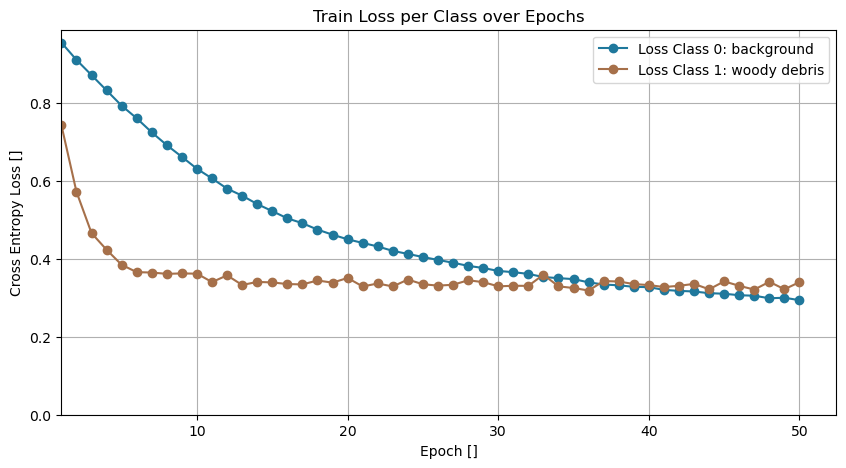

In [38]:
# Plot the train loss curves per class
visualization_utils.plot_loss_curves_per_class(train_class_wise_losses, "Train", 
                           configs_sc.HYPERPARAMETERS["num_classes"], reversed_codes,
                           configs_sc.HYPERPARAMETERS["custom_colors"])

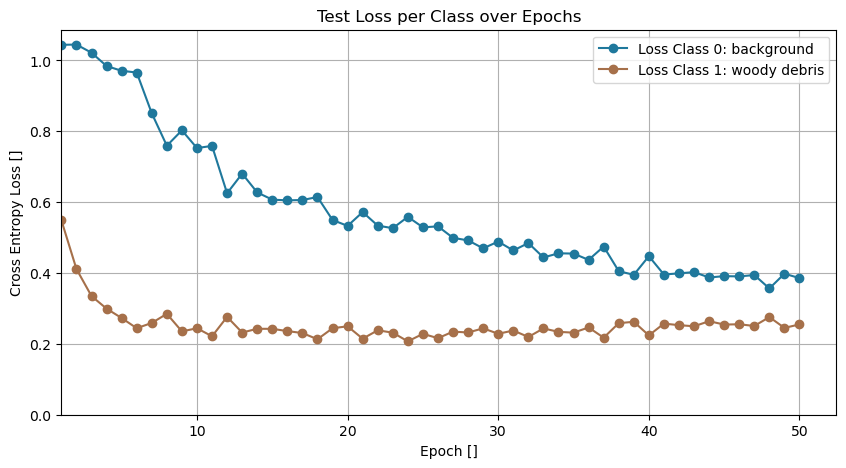

In [39]:
# Plot the test loss curves per class
visualization_utils.plot_loss_curves_per_class(test_class_wise_losses, "Test", 
                           configs_sc.HYPERPARAMETERS["num_classes"], reversed_codes,
                           configs_sc.HYPERPARAMETERS["custom_colors"])

## 5. Save and load trained model

### 5.1 Save model and loss values

1. Create individual name of the trained model

In [40]:
# model version
version = 1

# function for generating initial model name
def generate_model_name(base_name, num_classes, dataaug, epochs, version):
    return f"{base_name}_{num_classes}cls_{dataaug}aug_{epochs}ep_v{version}.pth"
    
base_name = "model"
if configs_sc.HYPERPARAMETERS["data_augmentation"] == True:
    dataaug = "data"
else:
    dataaug = "NOdata"

# generate initial name and path
MODEL_NAME = generate_model_name(base_name,  configs_sc.HYPERPARAMETERS["num_classes"],  dataaug, configs_sc.HYPERPARAMETERS["epochs"], version)
save_model_path = os.path.join(models_dir, MODEL_NAME)

# check if there is already a model saved with the same name -> if so: increase the counter
while os.path.exists(save_model_path):
    print(f"Warning: File with name {MODEL_NAME} already exists. Increase the counter...")
    version += 1
    MODEL_NAME = generate_model_name(base_name,  configs_sc.HYPERPARAMETERS["num_classes"],  dataaug, configs_sc.HYPERPARAMETERS["epochs"], version)
    save_model_path = os.path.join(models_dir, MODEL_NAME)

2. Save the models state dict

In [ ]:
print(f"Saving model to: {save_model_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=save_model_path)

Saving model to: /work/rf37uqip-MoSE_thesis/data/models/model_2cls_dataaug_50ep_v1.pth


3. Save and load loss values

In [ ]:
# Create a dictionary with your metrics
loss_values = {
    "train_loss_progress": train_loss_progress,
    "test_loss_progress": test_loss_progress,
    "train_class_wise_losses": train_class_wise_losses,
    "test_class_wise_losses": test_class_wise_losses
}

# Save the loss values to a file using pickle
with open(f"{models_dir}/loss_values_{MODEL_NAME}.pkl", "wb") as f:
    pickle.dump(loss_values, f)

print(f"{models_dir}loss_values_{MODEL_NAME}.pkl")

In [ ]:
with open(f"{models_dir}/loss_values_{MODEL_NAME}.pkl", "rb") as f:
    loaded_metrics = pickle.load(f)

### 5.2 Load the model

In [ ]:
#######
MODEL_NAME = "unet_model_2class_dataaugmentation_100_50_1.pth"
#######
print("Loaded model:", MODEL_NAME)

save_model_path = os.path.join(models_dir, MODEL_NAME)

# Create a new instance of the model (same class as our saved state_dict())
loaded_model = model_utils.model_0.to(device)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=save_model_path, weights_only=True))

# Send model to GPU
loaded_model = loaded_model.to(device)

## 6. Evaluate trained model

Make predictions for the entire test data set with the trained model and display the results in a confusion matrix.

### 6.1 Confusion Matrix Metrics
Accuracy, Precision, Recall and F1-Scores

Confusion Matrix for entire test data set!

In [ ]:
# predictions for entire test data set
evaluation_utils.evaluate_model_with_testdata(loaded_model, test_loader, accuracy_fn, configs_sc.HYPERPARAMETERS["num_classes"], device, F1_analysis = True)

### 6.2 Visual Evaluation

In [ ]:
##################### Choose single patch by section and id
SECTION = "A04" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 230 # -------------------->> ADJUSTABLE
#####################

test_patch_name = f"{SECTION}_patch_{TEST_PATCH_ID}.npy"

visualization_utils.visualize_prediction(test_patch_name, test_loader, loaded_model, device, 
                                         reversed_codes, configs_sc.HYPERPARAMETERS["custom_colors"], show = True)

In [ ]:
visualization_utils.visualize_all_test_patches(test_loader, loaded_model, device, reversed_codes, 
                           configs_sc.HYPERPARAMETERS["custom_colors"], 
                           output_pdf_base = f"{models_dir}visualPDF_{MODEL_NAME}")

## Citing

In [ ]:
# @misc{Iakubovskii:2019,
#   Author = {Pavel Iakubovskii},
#   Title = {Segmentation Models Pytorch},
#   Year = {2019},
#   Publisher = {GitHub},
#   Journal = {GitHub repository},
#   Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
# }